# 2021-07-23 Exploratory view

Go through the archives, have a look at the files, see what's inside at a basic level

Use p7zip in fedora, `p7a -x *.7z` or similar

SN3 was originally corrupt, new version was uploaded

## Contents

* SN2: Two subfolders
* SN3: Two subfolders
* SN5: Three subfolders
* SN6: Three subfolders

Very big on ASCII data, thus when unpacked it's about 1.1 gb and 300mb in a 7z

Could investigate other dataformats, compression, etc Note that bzip'd and pickled data in an sqlite database is still large

In [1]:
import os
import sqlite3
import re
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal


In [2]:
# Keeping data in nearby folder that's entered in .gitignore
os.listdir(os.path.join("..", "data"))

['SN2', 'SN2.7z', 'SN3', 'SN3.7z', 'SN5', 'SN5.7z', 'SN6', 'SN6.7z']

In [3]:
os.listdir(os.path.join("..", "Data", "SN2", "20200930_1500_"))

['Data.dat', 'Frames', 'SN2_Run1_Time_Data.txt']

`Data.dat` and `SN2_Run1_Time_Data.txt` appear to be the same data, except one of them has an extended header

In [4]:
os.listdir(os.path.join("..", "Data", "SN2", "20200930_1500_", "Frames"))[:5]

['20200930_150110__31127.dat',
 '20200930_150111__32126.dat',
 '20200930_150112__33127.dat',
 '20200930_150113__34128.dat',
 '20200930_150114__35130.dat']

The dat files appear to be an ascii space separated array of some sort

In [5]:
frame_path = os.path.join("..", "Data", "SN2", "20200930_1500_", "Frames")
frame_filenames = os.listdir(os.path.join(frame_path))

In [6]:
frame_filenames[:5], frame_filenames[-5:]

(['20200930_150110__31127.dat',
  '20200930_150111__32126.dat',
  '20200930_150112__33127.dat',
  '20200930_150113__34128.dat',
  '20200930_150114__35130.dat'],
 ['20200930_165456__6857346.dat',
  '20200930_165457__6858347.dat',
  '20200930_165458__6859347.dat',
  '20200930_165459__6860348.dat',
  '20200930_165500__6861349.dat'])

6825


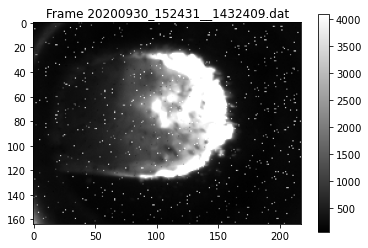

In [7]:
print(len(frame_filenames))
frame_name = frame_filenames[1400]
frame = np.genfromtxt(os.path.join(frame_path, frame_name))

fig, ax = plt.subplots()
imshow_result = ax.imshow(frame, cmap='gray')
fig.colorbar(imshow_result)
ax.set_title("Frame {}".format(frame_name))
plt.show()

6825


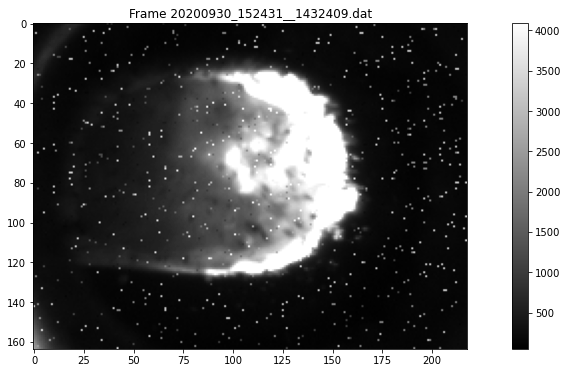

In [8]:
print(len(frame_filenames))
frame_name = frame_filenames[1400]
frame = np.genfromtxt(os.path.join(frame_path, frame_name))

fig, ax = plt.subplots(figsize=(16,6))
imshow_result = ax.imshow(frame, cmap='gray')
fig.colorbar(imshow_result)
ax.set_title("Frame {}".format(frame_name))
plt.show()

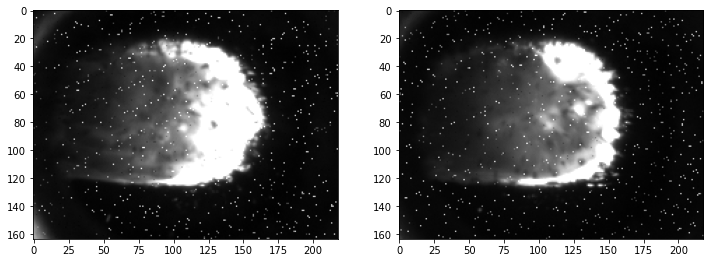

In [9]:

# Show successive images, to see how they change frame by frame
fig, axs = plt.subplots(1,2, figsize=(12,6))
ax = axs[0]
frame = np.genfromtxt(os.path.join(frame_path, frame_filenames[1401]))
imshow_result = ax.imshow(frame, cmap='gray')

ax = axs[1]
frame = np.genfromtxt(os.path.join(frame_path, frame_filenames[1402]))
imshow_result = ax.imshow(frame, cmap='gray')


plt.show()

In [10]:
print("Number of pixels: {}".format(frame.shape[0] * frame.shape[1]))

Number of pixels: 35752


Show the difference of two successive images, so see how things change frame by frame

Also include a histogram of pixel intensity change

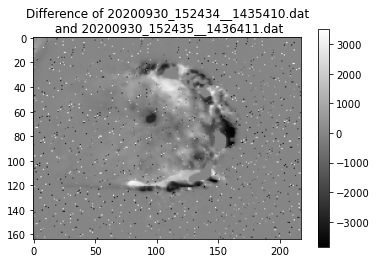

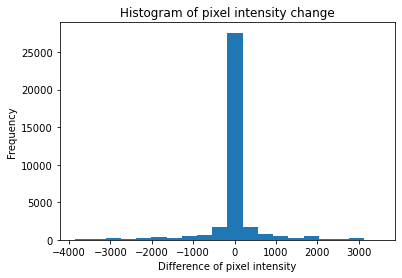

In [11]:
frame_idx = 1403
frame_1 = np.genfromtxt(os.path.join(frame_path, frame_filenames[frame_idx]))
frame_2 = np.genfromtxt(os.path.join(frame_path, frame_filenames[frame_idx+1]))
frame = frame_2 - frame_1

fig, ax = plt.subplots()
imshow_result = ax.imshow(frame, cmap='gray')
ax.set_title("Difference of {}\n and {}".format(frame_filenames[frame_idx], frame_filenames[frame_idx+1]))
fig.colorbar(imshow_result)
plt.show()

fig, ax = plt.subplots()
ax.hist(frame.flatten(), bins=20)
ax.set_xlabel("Difference of pixel intensity")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of pixel intensity change")
plt.show()

`Data.dat` is the same as `SN2_Run1_Time_Data.txt` but with extra metadata at the start

In [12]:
data_path = os.path.join("..", "data", "SN2", "20200930_1500_", "Data.dat")
def read_data(data_path):
    """
    Reads in .dat logfile
    """
    meta_data_lines = []
    with open(data_path, 'r') as a_file:
        for line in a_file:
            # Read the metadata in first, then halt at the empty line where the rest of the data begins
            if line != "\n":
                meta_data_lines.append(line)
            else:
                data_df = pd.read_csv(a_file, header=0, delimiter=' ')

    meta_data_dict = {}
    int_regex = re.compile(r"-?\d+$")
    float_regex = re.compile(r"-?\+?\d+\.?\d*e?\+?-?\d*$")
    meta_data_regex = re.compile(r"# (.*): (.*)\n")
    for line in meta_data_lines:
        match_result = meta_data_regex.match(line)
        key, value = match_result.groups()
        if int_regex.match(value):
            value = int(value)
            continue
        if float_regex.match(value):
            value = float(value)
        meta_data_dict[key] = value
    meta_data_dict["datetime"] = datetime.datetime.strptime(meta_data_dict["Date"], "%Y%m%d_%H%M_")
    data_df["t(s)"] = data_df["t"] * 1e-3
    data_df["t(min)"] = data_df["t(s)"] / 60
    
    return meta_data_dict, data_df

meta_data_dict, data_df = read_data(data_path)


In [13]:
def read_frame(frame_filepath):
    """
    """
    frame = np.genfromtxt(frame_filepath, dtype=int)
    return frame

In [14]:
meta_data_dict

{'Date': '20200930_1501_',
 'Programme name': '_N_1A_ALL_ADD__1_MPF',
 'SMARTKey ID of user': 'DummyUser',
 'UpperBound': 20000.0,
 'LowerBound': 12000.0,
 'TemperatureMeltThreshold': 1560.0,
 'TemperatureMeltThresholdHigh': 20800.0,
 'WarningNumberOfPixelsOverThreshold': 50000000.0,
 'WarningTimeNumberOfPixelsOverThreshold': 5000000.0,
 'ErrorTimeNumberOfPixelsOverThreshold': 0.0,
 'WarningFlowRateDeviationPercent': 100000.0,
 'WarningTimeFlowRateDeviationPercent': 1000000.0,
 'ErrorTimeFlowRateDeviationPercent': 0.0,
 'TargetMeltpoolArea': 8500.0,
 'MaxLaserPower': 2000.0,
 'MinLaserPower': 0.0,
 'StartLaserPower': 1800.0,
 'RestartLaserPower': 1800.0,
 'ControllerActivationThreshold': 0.8,
 'ControllerRestartActivationThreshold': 0.1,
 'RestartTimeWithoutLaserPowerReset': 0.04,
 'LaserPowerPercentIncrease': 0.0,
 'LaserPowerConstantIncrease': 0.0,
 'LaserPowerPercentIncreasePerSecond': 0.0,
 'LaserPowerConstantIncreasePerSecond': 0.0,
 'MaxLaserPowerRamp': 100000.0,
 'Kp': 0.1053,
 

In [15]:
data_df.head()

t    x    y    z    a    c  meltpoolSize  meltpoolTemp  LaserPower  \
0  31201  0.0  0.0  0.0  0.0  0.0          8700        1752.0        2000   
1  31301  0.0  0.0  0.0  0.0  0.0         10465        1747.0        2000   
2  31401  0.0  0.0  0.0  0.0  0.0         10132        1760.0        2000   
3  31501  0.0  0.0  0.0  0.0  0.0          9926        1764.0        2000   
4  31601  0.0  0.0  0.0  0.0  0.0         10454        1767.0        2000   

   stirrerValue_1  revolutionSpeed_1  powderGasFlow_1  stirrerValue_2  \
0             500                400              600               0   
1             500                400              600               0   
2             500                400              600               0   
3             500                400              600               0   
4             500                400              600               0   

   revolutionSpeed_2  powderGasFlow_2  flowWatch  meltpoolThreshold  \
0                  0                0       2872                506   
1                  0                0       2872                506   
2                  0                0       2872                506   
3                  0                0       2864                506   
4                  0                0       2864                506   

   protectionGlasTemperature    t(s)    t(min)  
0                       19.2  31.201  0.520017  
1                       19.2  31.301  0.521683  
2                       19.2  31.401  0.523350  
3                       19.2  31.501  0.525017  
4                       19.2  31.601  0.526683

In [16]:
# Add some extra time columns with explicit units, time was reported in NGIF Romar presentation as having units of ms
data_df["t(s)"] = data_df["t"] * 1e-3
data_df["t(min)"] = data_df["t(s)"] / 60

In [17]:
data_df.describe()

t             x             y             z             a  \
count  6.830400e+04  68304.000000  68304.000000  68304.000000  68304.000000   
mean   3.446359e+06      1.009847     -0.028667     97.754087      0.264079   
std    1.971786e+06     31.897758     29.234929     23.999534      4.504100   
min    3.120100e+04    -45.243000   -316.544000   -222.977000      0.000000   
25%    1.738780e+06    -27.147000    -26.814250     77.300000      0.000000   
50%    3.446355e+06      0.712000      0.905000     96.200000      0.000000   
75%    5.153939e+06     28.514500     26.923000    117.800000      0.000000   
max    6.861520e+06    675.000000     44.936000    534.993000    330.000000   

                  c  meltpoolSize  meltpoolTemp    LaserPower  stirrerValue_1  \
count  68304.000000  68304.000000  68304.000000  68304.000000    68304.000000   
mean      -0.101075  10571.575574   1686.662933   1262.613463      499.963399   
std        6.822384   4215.445158    481.368802    491.460342        4.277788   
min     -208.598000      0.000000     25.000000      0.000000        0.000000   
25%        0.000000  10589.000000   1771.000000   1350.000000      500.000000   
50%        0.000000  11898.000000   1808.000000   1400.000000      500.000000   
75%        0.000000  12920.250000   1863.000000   1450.000000      500.000000   
max      149.611000  14816.000000   1950.000000   2000.000000      500.000000   

       revolutionSpeed_1  powderGasFlow_1  stirrerValue_2  revolutionSpeed_2  \
count       68304.000000     68304.000000         68304.0            68304.0   
mean          399.970719       599.956079             0.0                0.0   
std             3.422230         5.133345             0.0                0.0   
min             0.000000         0.000000             0.0                0.0   
25%           400.000000       600.000000             0.0                0.0   
50%           400.000000       600.000000             0.0                0.0   
75%           400.000000       600.000000             0.0                0.0   
max           400.000000       600.000000             0.0                0.0   

       powderGasFlow_2     flowWatch  meltpoolThreshold  \
count          68304.0  68304.000000            68304.0   
mean               0.0   3353.447353              506.0   
std                0.0   6190.057397                0.0   
min                0.0      0.000000              506.0   
25%                0.0   2728.000000              506.0   
50%                0.0   2764.000000              506.0   
75%                0.0   2804.000000              506.0   
max                0.0  65532.000000              506.0   

       protectionGlasTemperature          t(s)        t(min)  
count               68304.000000  68304.000000  68304.000000  
mean                   34.364532   3446.358523     57.439309  
std                     2.547276   1971.785664     32.863094  
min                    19.200000     31.201000      0.520017  
25%                    33.000000   1738.780000     28.979667  
50%                    34.600000   3446.355000     57.439250  
75%                    36.000000   5153.939000     85.898983  
max                    39.300000   6861.520000    114.358667

In [18]:
len(frame_filenames), len(data_df)

(6825, 68304)

In [19]:
np.diff(data_df["t"]), np.mean(np.diff(data_df["t"])), np.std(np.diff(data_df["t"]))

(array([100, 100, 100, ..., 100, 100, 100], dtype=int64),
 100.00027817226183,
 0.21451216978429144)

Okay so:
* Stirrer value, revo value, powder gas flow 2 aren't used
* Melt pool threshold appears to be constant as well (material value?)
* Roughly 1 frame every 10 rows, each row roughly 100ms



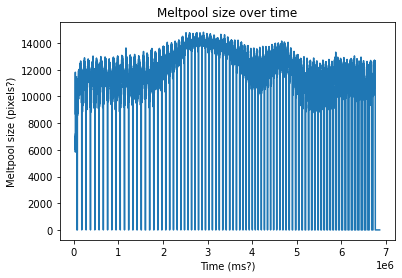

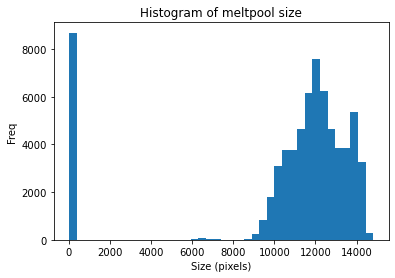

In [20]:
fig, ax = plt.subplots()
ax.plot(data_df["t"], data_df["meltpoolSize"])
ax.set_title("Meltpool size over time")
ax.set_xlabel("Time (ms?)")
ax.set_ylabel("Meltpool size (pixels?)")
plt.show()

fig, ax = plt.subplots()
ax.hist(data_df["meltpoolSize"], bins=40)
ax.set_title("Histogram of meltpool size")
ax.set_xlabel("Size (pixels)")
ax.set_ylabel("Freq")
plt.show()


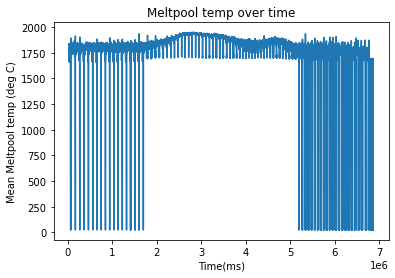

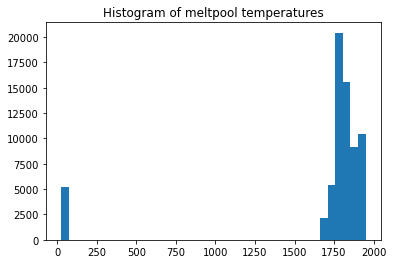

In [21]:
fig, ax = plt.subplots()
ax.plot(data_df["t"], data_df["meltpoolTemp"])
ax.set_title("Meltpool temp over time")
ax.set_xlabel("Time(ms)")
ax.set_ylabel("Mean Meltpool temp (deg C)")
plt.show()

fig, ax = plt.subplots()
ax.hist(data_df["meltpoolTemp"], bins=40)
ax.set_title("Histogram of meltpool temperatures")
plt.show()


Look at where and why we have low meltpool sizes

In [22]:
subset = data_df[
    data_df["meltpoolSize"] < 2000
]
subset

t        x        y        z        a        c  meltpoolSize  \
340      65201  -45.243    0.011   62.400   30.000 -114.541             0   
341      65301  -45.243    0.011   63.573   30.000 -114.541             0   
342      65401   -0.312  -21.490   34.382   89.592  -30.000             0   
343      65501  410.068 -316.544 -222.977  113.725  -30.000             0   
344      65601  410.068 -316.544 -215.777  113.725  -30.000             0   
...        ...      ...      ...      ...      ...      ...           ...   
68299  6861120   37.172    5.168  137.600    0.000    0.000             0   
68300  6861220   37.172    5.168  137.600    0.000    0.000             0   
68301  6861320   37.172    5.168  137.600    0.000    0.000             0   
68302  6861420   37.172    5.168  137.600    0.000    0.000             0   
68303  6861520   37.172    5.168  137.600    0.000    0.000             0   

       meltpoolTemp  LaserPower  stirrerValue_1  revolutionSpeed_1  \
340            25.0           0             500                400   
341            25.0           0             500                400   
342            25.0           0             500                400   
343            25.0           0             500                400   
344            25.0           0             500                400   
...             ...         ...             ...                ...   
68299          25.0           0               0                  0   
68300          25.0           0               0                  0   
68301          25.0           0               0                  0   
68302          25.0           0               0                  0   
68303          25.0           0               0                  0   

       powderGasFlow_1  stirrerValue_2  revolutionSpeed_2  powderGasFlow_2  \
340                600               0                  0                0   
341                600               0                  0                0   
342                600               0                  0                0   
343                600               0                  0                0   
344                600               0                  0                0   
...                ...             ...                ...              ...   
68299                0               0                  0                0   
68300                0               0                  0                0   
68301                0               0                  0                0   
68302                0               0                  0                0   
68303                0               0                  0                0   

       flowWatch  meltpoolThreshold  protectionGlasTemperature      t(s)  \
340         2796                506                       25.5    65.201   
341         2796                506                       25.5    65.301   
342         2796                506                       25.5    65.401   
343         2796                506                       25.6    65.501   
344         2796                506                       25.6    65.601   
...          ...                ...                        ...       ...   
68299       2804                506                       27.8  6861.120   
68300       2748                506                       27.8  6861.220   
68301       2748                506                       27.8  6861.320   
68302       2748                506                       27.8  6861.420   
68303       2748                506                       27.8  6861.520   

           t(min)  
340      1.086683  
341      1.088350  
342      1.090017  
343      1.091683  
344      1.093350  
...           ...  
68299  114.352000  
68300  114.353667  
68301  114.355333  
68302  114.357000  
68303  114.358667  

[8690 rows x 20 columns]

In [23]:
subset = data_df[
    (data_df["meltpoolSize"] > 5000)
    & (data_df["meltpoolSize"] < 8000)
]
subset

t       x       y        z    a    c  meltpoolSize  meltpoolTemp  \
14       32601   0.000   0.000    0.000  0.0  0.0          7220        1685.0   
15       32701   0.000   0.000    0.000  0.0  0.0          6473        1676.0   
16       32801   0.000   0.000    0.000  0.0  0.0          6395        1679.0   
17       32901   0.000   0.000    0.000  0.0  0.0          5836        1685.0   
18       33001   0.000   0.000    0.000  0.0  0.0          6123        1683.0   
...        ...     ...     ...      ...  ...  ...           ...           ...   
18545  1885705  16.976 -39.597   79.100  0.0  0.0          5681        1845.0   
20322  2063405 -42.130  -8.305   80.900  0.0  0.0          5645        1824.0   
57269  5758114 -37.629  11.658  126.645  0.0  0.0          7792        1900.0   
61437  6174914 -29.848 -25.036  131.300  0.0  0.0          7259        1858.0   
65957  6626918   0.881 -38.529  136.700  0.0  0.0          6111        1815.0   

       LaserPower  stirrerValue_1  revolutionSpeed_1  powderGasFlow_1  \
14           2000             500                400              600   
15           2000             500                400              600   
16           2000             500                400              600   
17           2000             500                400              600   
18           2000             500                400              600   
...           ...             ...                ...              ...   
18545        1450             500                400              600   
20322        1450             500                400              600   
57269        1450             500                400              600   
61437        1600             500                400              600   
65957        1600             500                400              600   

       stirrerValue_2  revolutionSpeed_2  powderGasFlow_2  flowWatch  \
14                  0                  0                0       2864   
15                  0                  0                0       2864   
16                  0                  0                0       2864   
17                  0                  0                0       2864   
18                  0                  0                0       2828   
...               ...                ...              ...        ...   
18545               0                  0                0       2776   
20322               0                  0                0       2740   
57269               0                  0                0       2692   
61437               0                  0                0       2888   
65957               0                  0                0       2904   

       meltpoolThreshold  protectionGlasTemperature      t(s)      t(min)  
14                   506                       19.3    32.601    0.543350  
15                   506                       19.3    32.701    0.545017  
16                   506                       19.3    32.801    0.546683  
17                   506                       19.3    32.901    0.548350  
18                   506                       19.3    33.001    0.550017  
...                  ...                        ...       ...         ...  
18545                506                       33.3  1885.705   31.428417  
20322                506                       34.2  2063.405   34.390083  
57269                506                       31.5  5758.114   95.968567  
61437                506                       30.8  6174.914  102.915233  
65957                506                       29.5  6626.918  110.448633  

[160 rows x 20 columns]

In [24]:
subset = data_df[
    (data_df["meltpoolSize"] > 8000)
    
]
subset

t       x      y      z    a    c  meltpoolSize  meltpoolTemp  \
0        31201   0.000  0.000    0.0  0.0  0.0          8700        1752.0   
1        31301   0.000  0.000    0.0  0.0  0.0         10465        1747.0   
2        31401   0.000  0.000    0.0  0.0  0.0         10132        1760.0   
3        31501   0.000  0.000    0.0  0.0  0.0          9926        1764.0   
4        31601   0.000  0.000    0.0  0.0  0.0         10454        1767.0   
...        ...     ...    ...    ...  ...  ...           ...           ...   
67302  6761419  36.277  9.401  137.6  0.0  0.0         12455        1802.0   
67303  6761519  36.580  8.189  137.6  0.0  0.0         12402        1772.0   
67304  6761619  36.832  6.964  137.6  0.0  0.0         12264        1760.0   
67305  6761719  37.065  5.736  137.6  0.0  0.0         12638        1767.0   
67306  6761819  37.172  5.168  137.6  0.0  0.0         11656        1695.0   

       LaserPower  stirrerValue_1  revolutionSpeed_1  powderGasFlow_1  \
0            2000             500                400              600   
1            2000             500                400              600   
2            2000             500                400              600   
3            2000             500                400              600   
4            2000             500                400              600   
...           ...             ...                ...              ...   
67302        1650             500                400              600   
67303        1650             500                400              600   
67304        1650             500                400              600   
67305        1650             500                400              600   
67306        1650             500                400              600   

       stirrerValue_2  revolutionSpeed_2  powderGasFlow_2  flowWatch  \
0                   0                  0                0       2872   
1                   0                  0                0       2872   
2                   0                  0                0       2872   
3                   0                  0                0       2864   
4                   0                  0                0       2864   
...               ...                ...              ...        ...   
67302               0                  0                0       2716   
67303               0                  0                0       2716   
67304               0                  0                0       2716   
67305               0                  0                0       2716   
67306               0                  0                0       2716   

       meltpoolThreshold  protectionGlasTemperature      t(s)      t(min)  
0                    506                       19.2    31.201    0.520017  
1                    506                       19.2    31.301    0.521683  
2                    506                       19.2    31.401    0.523350  
3                    506                       19.2    31.501    0.525017  
4                    506                       19.2    31.601    0.526683  
...                  ...                        ...       ...         ...  
67302                506                       35.6  6761.419  112.690317  
67303                506                       35.6  6761.519  112.691983  
67304                506                       35.6  6761.619  112.693650  
67305                506                       35.6  6761.719  112.695317  
67306                506                       35.6  6761.819  112.696983  

[59453 rows x 20 columns]

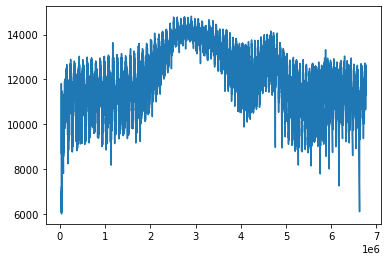

In [25]:
# Thresh meltpool size and plot

subset = data_df[
    data_df["meltpoolSize"] > 6000
]
fig, ax = plt.subplots()
ax.plot(subset["t"], subset["meltpoolSize"])
plt.show()

Lets zoom in on one of the spots where meltpool size and temp drop dramatically, link to laser power status

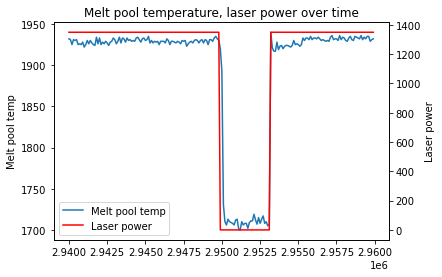

In [26]:
subset = data_df[
    (data_df["meltpoolTemp"] > 50)
    & (np.abs(data_df["t"] - 2.95e6) < 0.01e6)
]

fig, ax = plt.subplots()
ax.plot(subset["t"], subset["meltpoolTemp"], label="Melt pool temp")
ax2 = ax.twinx()
ax2.plot(subset["t"], subset["LaserPower"], label="Laser power", color="#FF0000FF")
ax2.set_ylabel("Laser power")
ax.set_ylabel("Melt pool temp")
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
ax.set_title("Melt pool temperature, laser power over time")
plt.show()

In [27]:
# Gap where temp drops down:

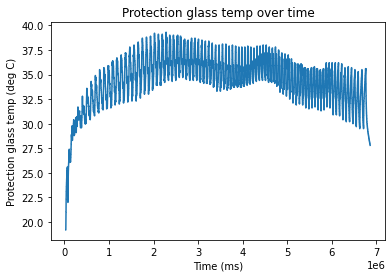

In [28]:
fig, ax = plt.subplots()
ax.plot(data_df["t"], data_df["protectionGlasTemperature"])
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Protection glass temp (deg C)")
ax.set_title("Protection glass temp over time")
plt.show()


In [29]:
data_df

t       x      y      z    a    c  meltpoolSize  meltpoolTemp  \
0        31201   0.000  0.000    0.0  0.0  0.0          8700        1752.0   
1        31301   0.000  0.000    0.0  0.0  0.0         10465        1747.0   
2        31401   0.000  0.000    0.0  0.0  0.0         10132        1760.0   
3        31501   0.000  0.000    0.0  0.0  0.0          9926        1764.0   
4        31601   0.000  0.000    0.0  0.0  0.0         10454        1767.0   
...        ...     ...    ...    ...  ...  ...           ...           ...   
68299  6861120  37.172  5.168  137.6  0.0  0.0             0          25.0   
68300  6861220  37.172  5.168  137.6  0.0  0.0             0          25.0   
68301  6861320  37.172  5.168  137.6  0.0  0.0             0          25.0   
68302  6861420  37.172  5.168  137.6  0.0  0.0             0          25.0   
68303  6861520  37.172  5.168  137.6  0.0  0.0             0          25.0   

       LaserPower  stirrerValue_1  revolutionSpeed_1  powderGasFlow_1  \
0            2000             500                400              600   
1            2000             500                400              600   
2            2000             500                400              600   
3            2000             500                400              600   
4            2000             500                400              600   
...           ...             ...                ...              ...   
68299           0               0                  0                0   
68300           0               0                  0                0   
68301           0               0                  0                0   
68302           0               0                  0                0   
68303           0               0                  0                0   

       stirrerValue_2  revolutionSpeed_2  powderGasFlow_2  flowWatch  \
0                   0                  0                0       2872   
1                   0                  0                0       2872   
2                   0                  0                0       2872   
3                   0                  0                0       2864   
4                   0                  0                0       2864   
...               ...                ...              ...        ...   
68299               0                  0                0       2804   
68300               0                  0                0       2748   
68301               0                  0                0       2748   
68302               0                  0                0       2748   
68303               0                  0                0       2748   

       meltpoolThreshold  protectionGlasTemperature      t(s)      t(min)  
0                    506                       19.2    31.201    0.520017  
1                    506                       19.2    31.301    0.521683  
2                    506                       19.2    31.401    0.523350  
3                    506                       19.2    31.501    0.525017  
4                    506                       19.2    31.601    0.526683  
...                  ...                        ...       ...         ...  
68299                506                       27.8  6861.120  114.352000  
68300                506                       27.8  6861.220  114.353667  
68301                506                       27.8  6861.320  114.355333  
68302                506                       27.8  6861.420  114.357000  
68303                506                       27.8  6861.520  114.358667  

[68304 rows x 20 columns]

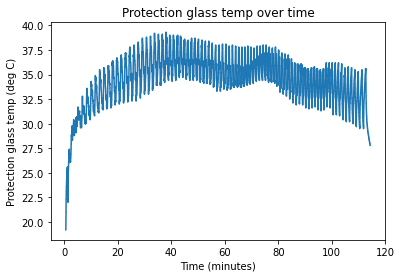

In [30]:
fig, ax = plt.subplots()
ax.plot(data_df["t(min)"], data_df["protectionGlasTemperature"])
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Protection glass temp (deg C)")
ax.set_title("Protection glass temp over time")
plt.show()

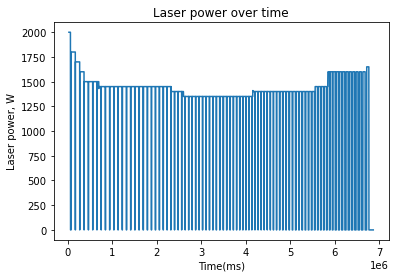

In [31]:
fig, ax = plt.subplots()
ax.plot(data_df["t"], data_df["LaserPower"])
ax.set_title("Laser power over time")
ax.set_xlabel("Time(ms)")
ax.set_ylabel("Laser power, W")
plt.show()

In [32]:
data_df.corr()

t         x         y         z         a  \
t                          1.000000 -0.007922  0.032284  0.956544 -0.100740   
x                         -0.007922  1.000000 -0.149243 -0.050269  0.371507   
y                          0.032284 -0.149243  1.000000  0.082454 -0.260985   
z                          0.956544 -0.050269  0.082454  1.000000 -0.187707   
a                         -0.100740  0.371507 -0.260985 -0.187707  1.000000   
c                          0.025425 -0.016449  0.050998  0.038364 -0.186916   
meltpoolSize              -0.299700 -0.082423  0.004564 -0.309508 -0.082206   
meltpoolTemp              -0.352340 -0.104083  0.006590 -0.357767 -0.090022   
LaserPower                -0.338887 -0.082593  0.005180 -0.330347 -0.021658   
stirrerValue_1            -0.014819 -0.009700 -0.001521 -0.014206  0.000502   
revolutionSpeed_1         -0.014819 -0.009700 -0.001521 -0.014206  0.000502   
powderGasFlow_1           -0.014819 -0.009700 -0.001521 -0.014206  0.000502   
stirrerValue_2                  NaN       NaN       NaN       NaN       NaN   
revolutionSpeed_2               NaN       NaN       NaN       NaN       NaN   
powderGasFlow_2                 NaN       NaN       NaN       NaN       NaN   
flowWatch                  0.146236 -0.000224  0.019668  0.144654 -0.005121   
meltpoolThreshold               NaN       NaN       NaN       NaN       NaN   
protectionGlasTemperature  0.078656 -0.096653  0.027782  0.033379 -0.236775   
t(s)                       1.000000 -0.007922  0.032284  0.956544 -0.100740   
t(min)                     1.000000 -0.007922  0.032284  0.956544 -0.100740   

                                  c  meltpoolSize  meltpoolTemp  LaserPower  \
t                          0.025425     -0.299700     -0.352340   -0.338887   
x                         -0.016449     -0.082423     -0.104083   -0.082593   
y                          0.050998      0.004564      0.006590    0.005180   
z                          0.038364     -0.309508     -0.357767   -0.330347   
a                         -0.186916     -0.082206     -0.090022   -0.021658   
c                          1.000000      0.011690      0.016226   -0.000826   
meltpoolSize               0.011690      1.000000      0.776872    0.908867   
meltpoolTemp               0.016226      0.776872      1.000000    0.753098   
LaserPower                -0.000826      0.908867      0.753098    1.000000   
stirrerValue_1            -0.000127      0.021457      0.029536    0.021982   
revolutionSpeed_1         -0.000127      0.021457      0.029536    0.021982   
powderGasFlow_1           -0.000127      0.021457      0.029536    0.021982   
stirrerValue_2                  NaN           NaN           NaN         NaN   
revolutionSpeed_2               NaN           NaN           NaN         NaN   
powderGasFlow_2                 NaN           NaN           NaN         NaN   
flowWatch                  0.001464     -0.239081     -0.324819   -0.244032   
meltpoolThreshold               NaN           NaN           NaN         NaN   
protectionGlasTemperature  0.054322      0.387799      0.360148    0.099412   
t(s)                       0.025425     -0.299700     -0.352340   -0.338887   
t(min)                     0.025425     -0.299700     -0.352340   -0.338887   

                           stirrerValue_1  revolutionSpeed_1  powderGasFlow_1  \
t                               -0.014819          -0.014819        -0.014819   
x                               -0.009700          -0.009700        -0.009700   
y                               -0.001521          -0.001521        -0.001521   
z                               -0.014206          -0.014206        -0.014206   
a                                0.000502           0.000502         0.000502   
c                               -0.000127          -0.000127        -0.000127   
meltpoolSize                     0.021457           0.021457         0.021457   
meltpoolTemp                     0.029536           0.029536      

Seems to be parts where the machine is working and parts where it isn't?

Main plots/visualiser:

* Meltpool size over time
* Powder flow over time
* Protection glass temp over time

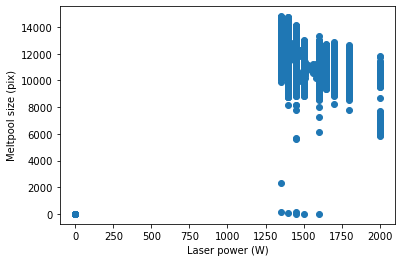

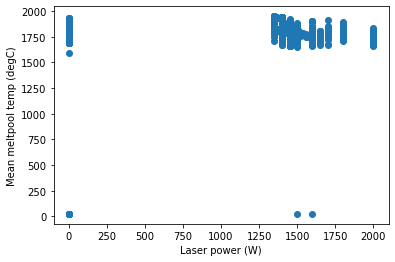

In [33]:
fig, ax = plt.subplots()
ax.scatter(data_df["LaserPower"], data_df["meltpoolSize"])
ax.set_xlabel("Laser power (W)")
ax.set_ylabel("Meltpool size (pix)")
plt.show()

fig, ax = plt.subplots()
ax.scatter(data_df["LaserPower"], data_df["meltpoolTemp"])
ax.set_xlabel("Laser power (W)")
ax.set_ylabel("Mean meltpool temp (degC)")
plt.show()

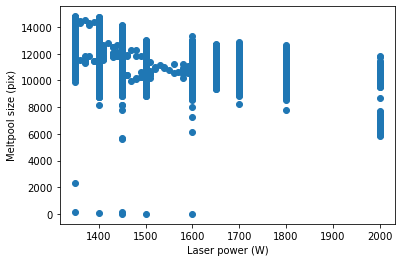

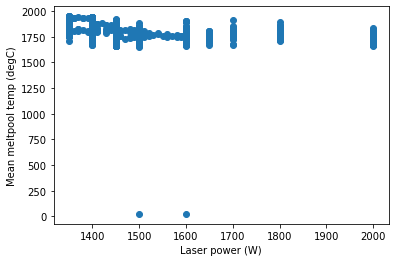

In [34]:
# Use Subset where laser is on
subset = data_df[
    data_df["LaserPower"] > 0
]

fig, ax = plt.subplots()
ax.scatter(subset["LaserPower"], subset["meltpoolSize"])
ax.set_xlabel("Laser power (W)")
ax.set_ylabel("Meltpool size (pix)")
plt.show()

fig, ax = plt.subplots()
ax.scatter(subset["LaserPower"], subset["meltpoolTemp"])
ax.set_xlabel("Laser power (W)")
ax.set_ylabel("Mean meltpool temp (degC)")
plt.show()


Lets plot meltpool size over time I guess then

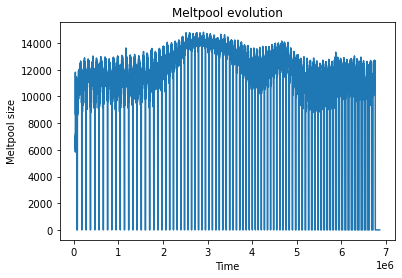

In [35]:
fig, ax = plt.subplots()
ax.plot(data_df["t"], data_df["meltpoolSize"])
ax.set_xlabel("Time")
ax.set_ylabel("Meltpool size")
ax.set_title("Meltpool evolution")
plt.show()

Looking at presentation, time is in ms, axii are in mm, rot axii are in mm, meltpool size in px, meltpool temp in deg C (from calibration curve/lookup tbale), laser power in W, stirrer value speed should be in % of maximum speed (but isn't?), rotation speed is in $10^-2$ per min?, transport powder/gas flow in  in $10^-2$l per min, meltpool threshold is the threshold at which a pixel is judged to be melted, prot glass temp in degc

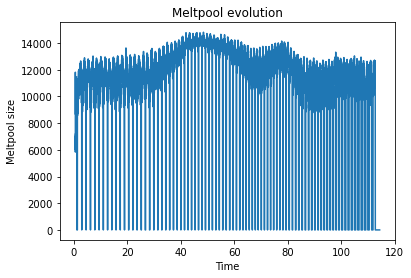

In [36]:
fig, ax = plt.subplots()
ax.plot(data_df["t(min)"], data_df["meltpoolSize"])
ax.set_xlabel("Time")
ax.set_ylabel("Meltpool size")
ax.set_title("Meltpool evolution")
plt.show()

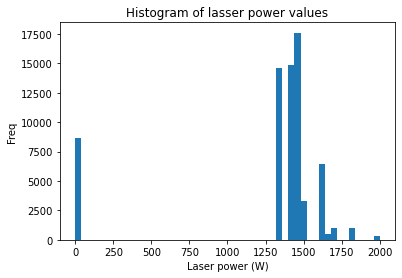

In [37]:
fig, ax = plt.subplots()
ax.hist(data_df["LaserPower"], bins=50)
ax.set_title("Histogram of lasser power values")
ax.set_xlabel("Laser power (W)")
ax.set_ylabel("Freq")
plt.show()

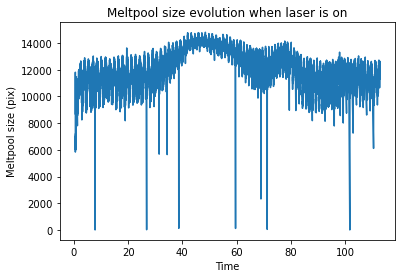

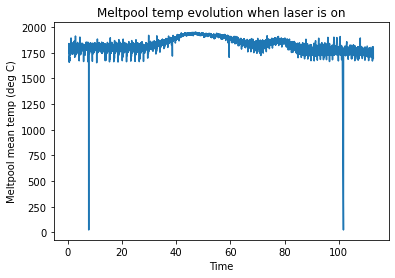

In [38]:
subset = data_df[
    (data_df["LaserPower"] > 1250)
    
]

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["meltpoolSize"])
ax.set_xlabel("Time")
ax.set_ylabel("Meltpool size (pix)")
ax.set_title("Meltpool size evolution when laser is on")
plt.show()

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["meltpoolTemp"])
ax.set_xlabel("Time")
ax.set_ylabel("Meltpool mean temp (deg C)")
ax.set_title("Meltpool temp evolution when laser is on")
plt.show()

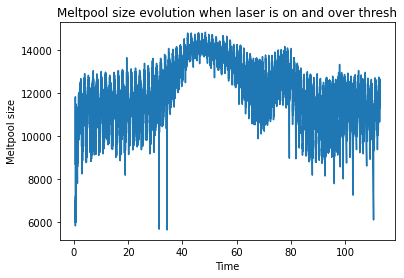

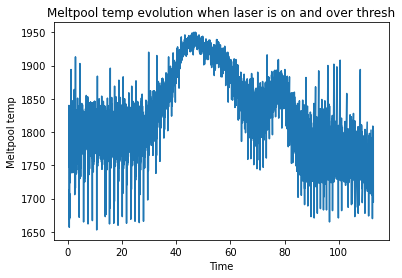

In [39]:
# Putting a minimum size thresh on, in case we're hitting times when the pool is just starting

thresh = 4000
subset = data_df[
    (data_df["LaserPower"] > 1250)
    & (data_df["meltpoolSize"] > thresh)
]

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["meltpoolSize"])
ax.set_xlabel("Time")
ax.set_ylabel("Meltpool size")
ax.set_title("Meltpool size evolution when laser is on and over thresh")
plt.show()

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["meltpoolTemp"])
ax.set_xlabel("Time")
ax.set_ylabel("Meltpool temp")
ax.set_title("Meltpool temp evolution when laser is on and over thresh")
plt.show()

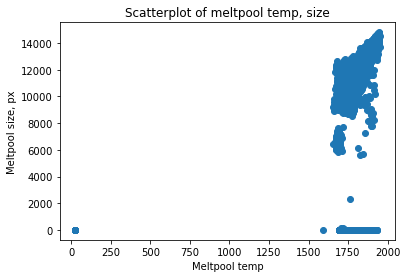

In [40]:
fig, ax = plt.subplots()
ax.scatter(data_df["meltpoolTemp"], data_df["meltpoolSize"])
ax.set_title("Scatterplot of meltpool temp, size")
ax.set_xlabel("Meltpool temp")
ax.set_ylabel("Meltpool size, px")
plt.show()

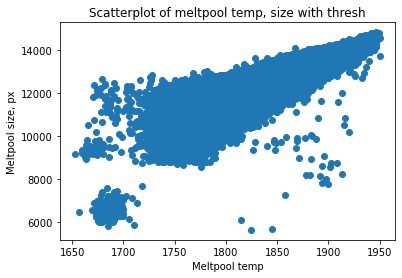

In [41]:
thresh = 4000
subset = data_df[
    (data_df["LaserPower"] > 1250)
    & (data_df["meltpoolSize"] > thresh)
]

fig, ax = plt.subplots()
ax.scatter(subset["meltpoolTemp"], subset["meltpoolSize"])
ax.set_title("Scatterplot of meltpool temp, size with thresh")
ax.set_xlabel("Meltpool temp")
ax.set_ylabel("Meltpool size, px")
plt.show()

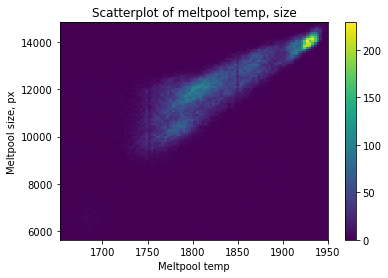

In [42]:
thresh = 4000
subset = data_df[
    (data_df["LaserPower"] > 1250)
    & (data_df["meltpoolSize"] > thresh)
]

fig, ax = plt.subplots()
hist_result = ax.hist2d(subset["meltpoolTemp"], subset["meltpoolSize"], bins=100)
ax.set_title("Scatterplot of meltpool temp, size")
ax.set_xlabel("Meltpool temp")
ax.set_ylabel("Meltpool size, px")
fig.colorbar(hist_result[3])
plt.show()

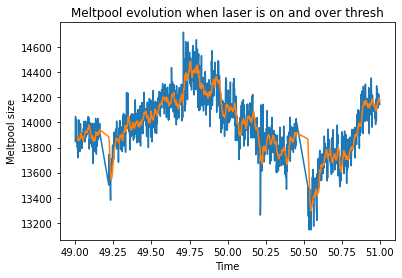

In [43]:
thresh = 4000
subset = data_df[
    (data_df["LaserPower"] > 1250)
    & (data_df["meltpoolSize"] > thresh)
    & (np.abs(data_df["t(min)"] - 50) < 1)
]

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["meltpoolSize"], label="Melt pool size as rep")
ax.plot(subset["t(min)"], subset["meltpoolSize"].rolling(10).mean(), label="Rolling mean")
ax.set_xlabel("Time")
ax.set_ylabel("Meltpool size")
ax.set_title("Meltpool evolution when laser is on and over thresh")
plt.show()

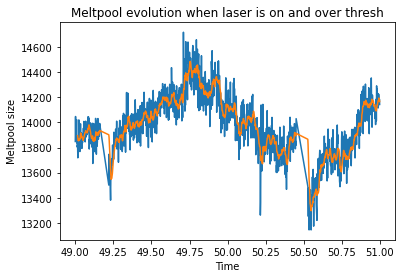

In [44]:
# Same but previous row must have had laser on
thresh = 4000
subset = data_df[
    (data_df["LaserPower"] > 1250)
    & (data_df["LaserPower"].shift(-1) > 1250)
    & (data_df["LaserPower"].shift(-2) > 1250)
    & (data_df["meltpoolSize"] > thresh)
    & (np.abs(data_df["t(min)"] - 50) < 1)
    

]

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["meltpoolSize"], label="Melt pool size as rep")
ax.plot(subset["t(min)"], subset["meltpoolSize"].rolling(10).mean(), label="Rolling mean")
ax.set_xlabel("Time")
ax.set_ylabel("Meltpool size")
ax.set_title("Meltpool evolution when laser is on and over thresh")
plt.show()

In [45]:
subset = data_df[
    (data_df["LaserPower"] > 0)
    & (data_df["meltpoolTemp"] < 1000)
]
subset

t       x       y        z    a    c  meltpoolSize  meltpoolTemp  \
4380    469203  41.746 -14.357   65.600  0.0  0.0             0          25.0   
60706  6101814  -0.807 -39.019  131.143  0.0  0.0             0          25.0   

       LaserPower  stirrerValue_1  revolutionSpeed_1  powderGasFlow_1  \
4380         1500             500                400              600   
60706        1600             500                400              600   

       stirrerValue_2  revolutionSpeed_2  powderGasFlow_2  flowWatch  \
4380                0                  0                0       2756   
60706               0                  0                0       2992   

       meltpoolThreshold  protectionGlasTemperature      t(s)     t(min)  
4380                 506                       30.5   469.203    7.82005  
60706                506                       31.0  6101.814  101.69690

In [46]:
subset = data_df[
    (data_df["LaserPower"] > 0)
    & (data_df["meltpoolSize"] < 7000)
]
subset

t       x       y        z    a    c  meltpoolSize  meltpoolTemp  \
15       32701   0.000   0.000    0.000  0.0  0.0          6473        1676.0   
16       32801   0.000   0.000    0.000  0.0  0.0          6395        1679.0   
17       32901   0.000   0.000    0.000  0.0  0.0          5836        1685.0   
18       33001   0.000   0.000    0.000  0.0  0.0          6123        1683.0   
19       33101   0.000   0.000    0.000  0.0  0.0          6138        1684.0   
...        ...     ...     ...      ...  ...  ...           ...           ...   
35437  3574905  22.113 -35.228   98.000  0.0  0.0           111        1706.0   
41055  4136709  -7.614 -40.313  105.200  0.0  0.0          2320        1764.0   
42448  4276010 -37.502  16.281  107.000  0.0  0.0            40        1724.0   
60706  6101814  -0.807 -39.019  131.143  0.0  0.0             0          25.0   
65957  6626918   0.881 -38.529  136.700  0.0  0.0          6111        1815.0   

       LaserPower  stirrerValue_1  revolutionSpeed_1  powderGasFlow_1  \
15           2000             500                400              600   
16           2000             500                400              600   
17           2000             500                400              600   
18           2000             500                400              600   
19           2000             500                400              600   
...           ...             ...                ...              ...   
35437        1350             500                400              600   
41055        1350             500                400              600   
42448        1400             500                400              600   
60706        1600             500                400              600   
65957        1600             500                400              600   

       stirrerValue_2  revolutionSpeed_2  powderGasFlow_2  flowWatch  \
15                  0                  0                0       2864   
16                  0                  0                0       2864   
17                  0                  0                0       2864   
18                  0                  0                0       2828   
19                  0                  0                0       2828   
...               ...                ...              ...        ...   
35437               0                  0                0       2716   
41055               0                  0                0       2712   
42448               0                  0                0       2712   
60706               0                  0                0       2992   
65957               0                  0                0       2904   

       meltpoolThreshold  protectionGlasTemperature      t(s)      t(min)  
15                   506                       19.3    32.701    0.545017  
16                   506                       19.3    32.801    0.546683  
17                   506                       19.3    32.901    0.548350  
18                   506                       19.3    33.001    0.550017  
19                   506                       19.3    33.101    0.551683  
...                  ...                        ...       ...         ...  
35437                506                       33.8  3574.905   59.581750  
41055                506                       35.0  4136.709   68.945150  
42448                506                       36.6  4276.010   71.266833  
60706                506                       31.0  6101.814  101.696900  
65957                506                       29.5  6626.918  110.448633  

[141 rows x 20 columns]

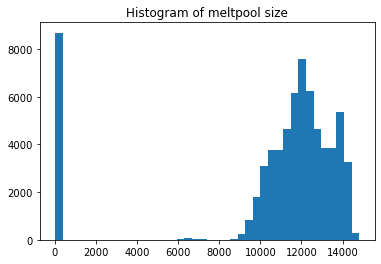

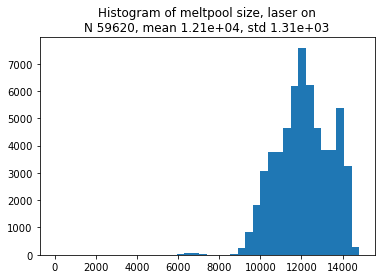

In [47]:
fig, ax = plt.subplots()
ax.hist(data_df["meltpoolSize"], bins=40)
ax.set_title("Histogram of meltpool size")
plt.show()

subset = data_df[
    data_df["LaserPower"] > 0
]
fig, ax = plt.subplots()
ax.hist(subset["meltpoolSize"], bins=40)
ax.set_title("Histogram of meltpool size, laser on\nN {}, mean {:.3g}, std {:.3g}".format(
    len(subset), np.mean(subset["meltpoolSize"]), np.std(subset["meltpoolSize"]))
)
plt.show()

Laser just switching on events seem to be rare

In [48]:
subset

t       x      y      z    a    c  meltpoolSize  meltpoolTemp  \
0        31201   0.000  0.000    0.0  0.0  0.0          8700        1752.0   
1        31301   0.000  0.000    0.0  0.0  0.0         10465        1747.0   
2        31401   0.000  0.000    0.0  0.0  0.0         10132        1760.0   
3        31501   0.000  0.000    0.0  0.0  0.0          9926        1764.0   
4        31601   0.000  0.000    0.0  0.0  0.0         10454        1767.0   
...        ...     ...    ...    ...  ...  ...           ...           ...   
67302  6761419  36.277  9.401  137.6  0.0  0.0         12455        1802.0   
67303  6761519  36.580  8.189  137.6  0.0  0.0         12402        1772.0   
67304  6761619  36.832  6.964  137.6  0.0  0.0         12264        1760.0   
67305  6761719  37.065  5.736  137.6  0.0  0.0         12638        1767.0   
67306  6761819  37.172  5.168  137.6  0.0  0.0         11656        1695.0   

       LaserPower  stirrerValue_1  revolutionSpeed_1  powderGasFlow_1  \
0            2000             500                400              600   
1            2000             500                400              600   
2            2000             500                400              600   
3            2000             500                400              600   
4            2000             500                400              600   
...           ...             ...                ...              ...   
67302        1650             500                400              600   
67303        1650             500                400              600   
67304        1650             500                400              600   
67305        1650             500                400              600   
67306        1650             500                400              600   

       stirrerValue_2  revolutionSpeed_2  powderGasFlow_2  flowWatch  \
0                   0                  0                0       2872   
1                   0                  0                0       2872   
2                   0                  0                0       2872   
3                   0                  0                0       2864   
4                   0                  0                0       2864   
...               ...                ...              ...        ...   
67302               0                  0                0       2716   
67303               0                  0                0       2716   
67304               0                  0                0       2716   
67305               0                  0                0       2716   
67306               0                  0                0       2716   

       meltpoolThreshold  protectionGlasTemperature      t(s)      t(min)  
0                    506                       19.2    31.201    0.520017  
1                    506                       19.2    31.301    0.521683  
2                    506                       19.2    31.401    0.523350  
3                    506                       19.2    31.501    0.525017  
4                    506                       19.2    31.601    0.526683  
...                  ...                        ...       ...         ...  
67302                506                       35.6  6761.419  112.690317  
67303                506                       35.6  6761.519  112.691983  
67304                506                       35.6  6761.619  112.693650  
67305                506                       35.6  6761.719  112.695317  
67306                506                       35.6  6761.819  112.696983  

[59620 rows x 20 columns]

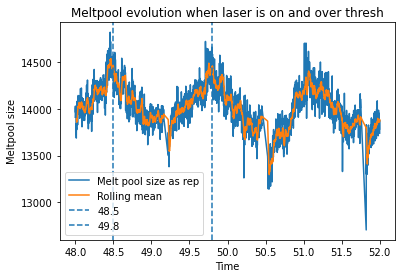

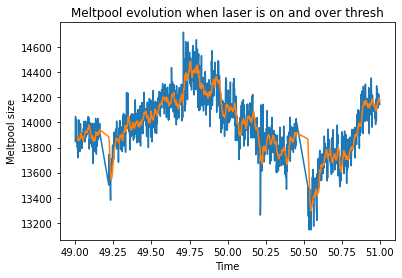

In [49]:
thresh = 4000
subset = data_df[
    (data_df["LaserPower"] > 1250)
    & (data_df["meltpoolSize"] > thresh)
    & (np.abs(data_df["t(min)"] - 50) < 2)
]

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["meltpoolSize"], label="Melt pool size as rep")
ax.plot(subset["t(min)"], subset["meltpoolSize"].rolling(10).mean(), label="Rolling mean")
ax.set_xlabel("Time")
ax.set_ylabel("Meltpool size")
ax.set_title("Meltpool evolution when laser is on and over thresh")
line = 48.5; ax.axvline(line, label="{}".format(line), linestyle="--")
line = 48.5 + 1.3; ax.axvline(line, label="{}".format(line), linestyle="--")
ax.legend()
plt.show()

thresh = 4000
subset = data_df[
    (data_df["LaserPower"] > 1250)
    & (data_df["meltpoolSize"] > thresh)
    & (np.abs(data_df["t(min)"] - 50) < 1)
]

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["meltpoolSize"], label="Melt pool size as rep")
ax.plot(subset["t(min)"], subset["meltpoolSize"].rolling(10).mean(), label="Rolling mean")
ax.set_xlabel("Time")
ax.set_ylabel("Meltpool size")
ax.set_title("Meltpool evolution when laser is on and over thresh")
plt.show()

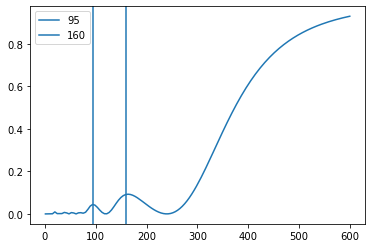

In [50]:
# Do a lomb scargle to look at variation freq
thresh = 4000
subset = data_df[
    (data_df["LaserPower"] > 1250)
    & (data_df["meltpoolSize"] > thresh)
    & (np.abs(data_df["t(min)"] - 50) < 2)
]
periods = np.linspace(1, 600, 130) # Look at stuff with period from once a second to once every 10 min
freqs = periods**-1*(2 * np.pi)
result = scipy.signal.lombscargle(subset["t(s)"], subset["meltpoolSize"], freqs, normalize=True)

fig, ax = plt.subplots()
ax.plot(periods, result)
line = 95; ax.axvline(line, label="{}".format(line))
line = 160; ax.axvline(line, label="{}".format(line))
ax.legend()
plt.show()

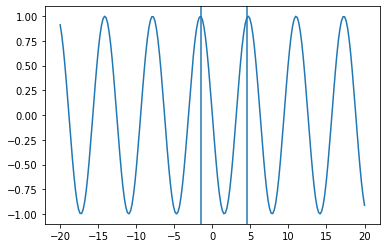

No handles with labels found to put in legend.


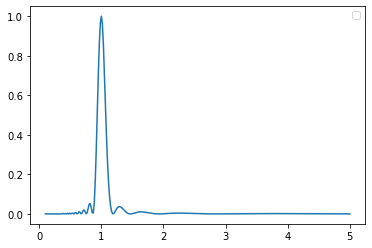

In [51]:
# Double checking I've got the freqs around properly
ts = np.linspace(-20, 20, 200)

error_mag = 0
ys = np.sin(1 * ts + np.pi) + np.random.uniform(-error_mag, error_mag, size=ts.shape)
# ys = ys + 0.5 * np.sin(2 * ts + np.pi) + np.random.uniform(-error_mag, error_mag, size=ts.shape)

fig, ax = plt.subplots()
ax.plot(ts, ys)
ax.axvline(-1.5)
ax.axvline(4.5)
plt.show()

periods = np.linspace(0.1, 5, 300) # Look at stuff with period from once a second to once every 10 min
freqs = periods**-1 
result = scipy.signal.lombscargle(ts, ys, freqs, normalize=True)

fig, ax = plt.subplots()
ax.plot(periods, result)
# line = 95; ax.axvline(line, label="{}".format(line))
ax.legend()
plt.show()

Variation with around period of 1.5min

In [52]:
thresh = 4000
subset = data_df[
    (data_df["LaserPower"] > 1250)
    & (data_df["meltpoolSize"] > thresh)
    & (np.abs(data_df["t(min)"] - 50) < 1)
]

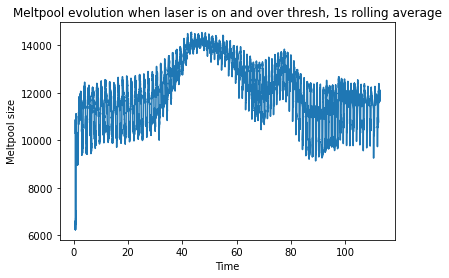

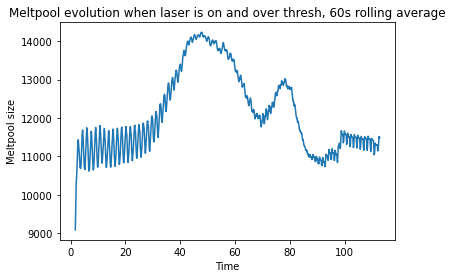

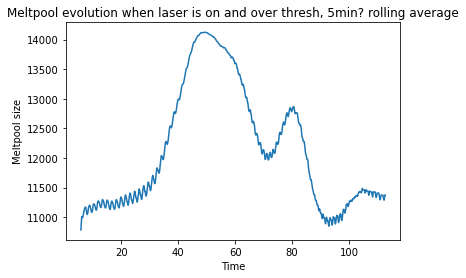

In [53]:
# Do a rolling average over a second or so
thresh = 4000
subset = data_df[
    (data_df["LaserPower"] > 1250)
    & (data_df["meltpoolSize"] > thresh)
]

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["meltpoolSize"].rolling(10).mean())
ax.set_xlabel("Time")
ax.set_ylabel("Meltpool size")
ax.set_title("Meltpool evolution when laser is on and over thresh, 1s rolling average")
plt.show()

# Do a rolling average over a second or so
thresh = 4000
subset = data_df[
    (data_df["LaserPower"] > 1250)
    & (data_df["meltpoolSize"] > thresh)
]

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["meltpoolSize"].rolling(10*60).mean())
ax.set_xlabel("Time")
ax.set_ylabel("Meltpool size")
ax.set_title("Meltpool evolution when laser is on and over thresh, 60s rolling average")
plt.show()


fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["meltpoolSize"].rolling(10*60*5).mean())
ax.set_xlabel("Time")
ax.set_ylabel("Meltpool size")
ax.set_title("Meltpool evolution when laser is on and over thresh, 5min? rolling average")
plt.show()

Powder flow meant to be the biggest source of random fluctuations

In [54]:
data_df.head()

t    x    y    z    a    c  meltpoolSize  meltpoolTemp  LaserPower  \
0  31201  0.0  0.0  0.0  0.0  0.0          8700        1752.0        2000   
1  31301  0.0  0.0  0.0  0.0  0.0         10465        1747.0        2000   
2  31401  0.0  0.0  0.0  0.0  0.0         10132        1760.0        2000   
3  31501  0.0  0.0  0.0  0.0  0.0          9926        1764.0        2000   
4  31601  0.0  0.0  0.0  0.0  0.0         10454        1767.0        2000   

   stirrerValue_1  revolutionSpeed_1  powderGasFlow_1  stirrerValue_2  \
0             500                400              600               0   
1             500                400              600               0   
2             500                400              600               0   
3             500                400              600               0   
4             500                400              600               0   

   revolutionSpeed_2  powderGasFlow_2  flowWatch  meltpoolThreshold  \
0                  0                0       2872                506   
1                  0                0       2872                506   
2                  0                0       2872                506   
3                  0                0       2864                506   
4                  0                0       2864                506   

   protectionGlasTemperature    t(s)    t(min)  
0                       19.2  31.201  0.520017  
1                       19.2  31.301  0.521683  
2                       19.2  31.401  0.523350  
3                       19.2  31.501  0.525017  
4                       19.2  31.601  0.526683

In [55]:
data_df.describe()

t             x             y             z             a  \
count  6.830400e+04  68304.000000  68304.000000  68304.000000  68304.000000   
mean   3.446359e+06      1.009847     -0.028667     97.754087      0.264079   
std    1.971786e+06     31.897758     29.234929     23.999534      4.504100   
min    3.120100e+04    -45.243000   -316.544000   -222.977000      0.000000   
25%    1.738780e+06    -27.147000    -26.814250     77.300000      0.000000   
50%    3.446355e+06      0.712000      0.905000     96.200000      0.000000   
75%    5.153939e+06     28.514500     26.923000    117.800000      0.000000   
max    6.861520e+06    675.000000     44.936000    534.993000    330.000000   

                  c  meltpoolSize  meltpoolTemp    LaserPower  stirrerValue_1  \
count  68304.000000  68304.000000  68304.000000  68304.000000    68304.000000   
mean      -0.101075  10571.575574   1686.662933   1262.613463      499.963399   
std        6.822384   4215.445158    481.368802    491.460342        4.277788   
min     -208.598000      0.000000     25.000000      0.000000        0.000000   
25%        0.000000  10589.000000   1771.000000   1350.000000      500.000000   
50%        0.000000  11898.000000   1808.000000   1400.000000      500.000000   
75%        0.000000  12920.250000   1863.000000   1450.000000      500.000000   
max      149.611000  14816.000000   1950.000000   2000.000000      500.000000   

       revolutionSpeed_1  powderGasFlow_1  stirrerValue_2  revolutionSpeed_2  \
count       68304.000000     68304.000000         68304.0            68304.0   
mean          399.970719       599.956079             0.0                0.0   
std             3.422230         5.133345             0.0                0.0   
min             0.000000         0.000000             0.0                0.0   
25%           400.000000       600.000000             0.0                0.0   
50%           400.000000       600.000000             0.0                0.0   
75%           400.000000       600.000000             0.0                0.0   
max           400.000000       600.000000             0.0                0.0   

       powderGasFlow_2     flowWatch  meltpoolThreshold  \
count          68304.0  68304.000000            68304.0   
mean               0.0   3353.447353              506.0   
std                0.0   6190.057397                0.0   
min                0.0      0.000000              506.0   
25%                0.0   2728.000000              506.0   
50%                0.0   2764.000000              506.0   
75%                0.0   2804.000000              506.0   
max                0.0  65532.000000              506.0   

       protectionGlasTemperature          t(s)        t(min)  
count               68304.000000  68304.000000  68304.000000  
mean                   34.364532   3446.358523     57.439309  
std                     2.547276   1971.785664     32.863094  
min                    19.200000     31.201000      0.520017  
25%                    33.000000   1738.780000     28.979667  
50%                    34.600000   3446.355000     57.439250  
75%                    36.000000   5153.939000     85.898983  
max                    39.300000   6861.520000    114.358667

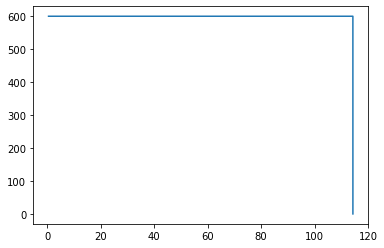

In [56]:
fig, ax = plt.subplots()
ax.plot(data_df["t(min)"], data_df["powderGasFlow_1"])
plt.show()



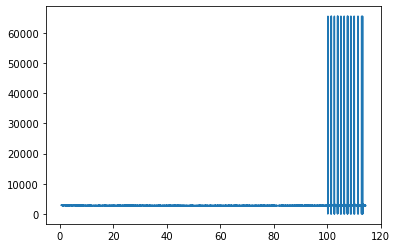

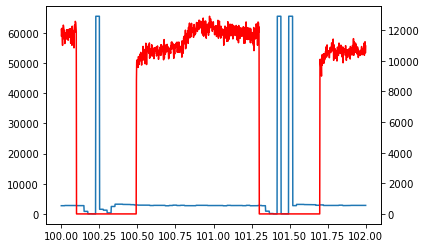

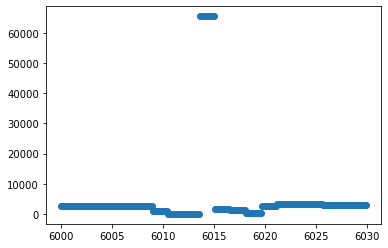

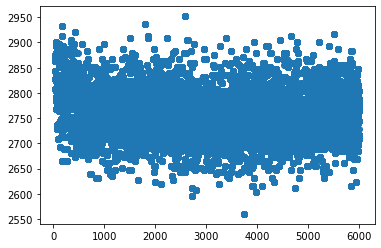

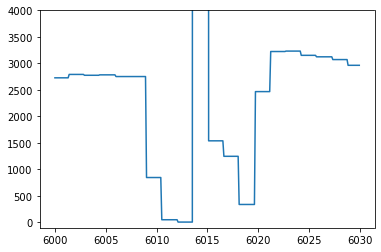

In [57]:
subset = data_df[
    (data_df["t(min)"] > 0)

]

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["flowWatch"])
plt.show()

subset = data_df[
    (data_df["t(min)"] > 100)
    & (data_df["t(min)"] < 102)
]

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["flowWatch"])
# Checking if flow issues show up in something else
ax2 = ax.twinx()
ax2.plot(subset["t(min)"], subset["meltpoolSize"], color="#FF0000FF")
# ax2 = ax.twinx()
# ax2.plot(subset["t(min)"], subset["meltpoolTemp"], color="#00FF00FF")


plt.show()

subset = data_df[
    (data_df["t(min)"] > 100)
    & (data_df["t(min)"] < 100.5)
]

fig, ax = plt.subplots()
ax.scatter(subset["t(s)"], subset["flowWatch"])
plt.show()

subset = data_df[
    (data_df["t(min)"] < 100)
    
]

fig, ax = plt.subplots()
ax.scatter(subset["t(s)"], subset["flowWatch"])
plt.show()


subset = data_df[
    (data_df["t(min)"] > 100)
    & (data_df["t(min)"] < 100.5)
]

fig, ax = plt.subplots()
ax.plot(subset["t(s)"], subset["flowWatch"])
ax.set_ylim(ax.get_ylim()[0], 10000)
ax.set_ylim(-100, 4000)
plt.show()

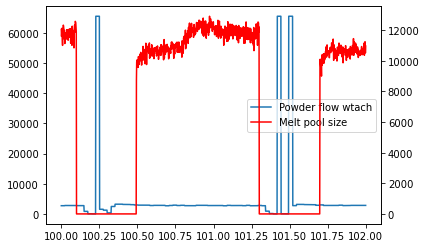

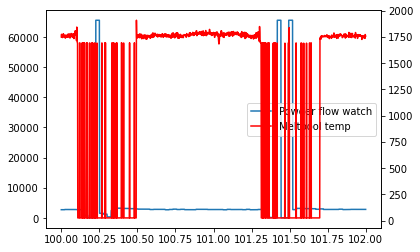

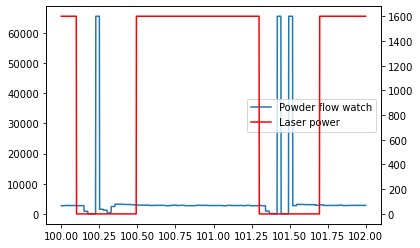

In [58]:
# Checking if flow issues show up in something else

subset = data_df[
    (data_df["t(min)"] > 100)
    & (data_df["t(min)"] < 102)
]

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["flowWatch"], label="Powder flow wtach")
ax2 = ax.twinx()
ax2.plot(subset["t(min)"], subset["meltpoolSize"], color="#FF0000FF", label="Melt pool size")
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
plt.show()

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["flowWatch"], label="Powder flow watch")
ax2 = ax.twinx()
ax2.plot(subset["t(min)"], subset["meltpoolTemp"], color="#FF0000FF", label="Meltpool temp")
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
plt.show()

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["flowWatch"], label="Powder flow watch")
ax2 = ax.twinx()
ax2.plot(subset["t(min)"], subset["LaserPower"], color="#FF0000FF", label="Laser power")
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
plt.show()

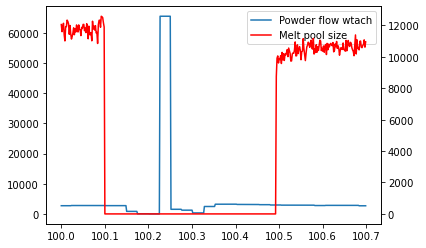

In [59]:
subset = data_df[
    (data_df["t(min)"] > 100)
    & (data_df["t(min)"] < 100.7)
]

fig, ax = plt.subplots()
ax.plot(subset["t(min)"], subset["flowWatch"], label="Powder flow wtach")
ax2 = ax.twinx()
ax2.plot(subset["t(min)"], subset["meltpoolSize"], color="#FF0000FF", label="Melt pool size")
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
plt.show()

In [60]:
subset["t"].median(), subset["t"].min(), subset["t"].max()

(6020964.0, 6000014, 6041914)

In [61]:
# Have a look at frames near where that happened
time_regex = re.compile(r"\d+_\d+__(\d+)\.dat")
grab_func = lambda x: float(time_regex.match(x).groups()[0])
subset_times = np.array([grab_func(i) for i in frame_filenames])
roi_frame_names = np.array(frame_filenames)[(subset_times > subset["t"].min()) & (subset_times < subset["t"].max())]
print(roi_frame_names)


['20200930_164039__6000565.dat' '20200930_164040__6001566.dat'
 '20200930_164041__6002567.dat' '20200930_164042__6003568.dat'
 '20200930_164043__6004568.dat' '20200930_164044__6005569.dat'
 '20200930_164045__6006570.dat' '20200930_164046__6007571.dat'
 '20200930_164047__6008572.dat' '20200930_164048__6009573.dat'
 '20200930_164049__6010574.dat' '20200930_164050__6011576.dat'
 '20200930_164051__6012575.dat' '20200930_164052__6013576.dat'
 '20200930_164053__6014578.dat' '20200930_164054__6015579.dat'
 '20200930_164055__6016580.dat' '20200930_164056__6017581.dat'
 '20200930_164057__6018581.dat' '20200930_164058__6019582.dat'
 '20200930_164059__6020583.dat' '20200930_164100__6021584.dat'
 '20200930_164101__6022585.dat' '20200930_164102__6023586.dat'
 '20200930_164103__6024586.dat' '20200930_164104__6025587.dat'
 '20200930_164105__6026588.dat' '20200930_164106__6027589.dat'
 '20200930_164107__6028590.dat' '20200930_164108__6029591.dat'
 '20200930_164109__6030592.dat' '20200930_164110__60315

In [62]:
subset[np.abs(subset["t"] - 6016580) < 200]

t       x      y      z    a    c  meltpoolSize  meltpoolTemp  \
59852  6016414  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59853  6016514  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59854  6016614  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59855  6016714  37.525 -0.602  128.6  0.0  0.0             0          25.0   

       LaserPower  stirrerValue_1  revolutionSpeed_1  powderGasFlow_1  \
59852           0             500                400              600   
59853           0             500                400              600   
59854           0             500                400              600   
59855           0             500                400              600   

       stirrerValue_2  revolutionSpeed_2  powderGasFlow_2  flowWatch  \
59852               0                  0                0       1540   
59853               0                  0                0       1540   
59854               0                  0                0       1248   
59855               0                  0                0       1248   

       meltpoolThreshold  protectionGlasTemperature      t(s)      t(min)  
59852                506                       32.7  6016.414  100.273567  
59853                506                       32.7  6016.514  100.275233  
59854                506                       32.7  6016.614  100.276900  
59855                506                       32.7  6016.714  100.278567

In [63]:
# Have a look around where the powder flow blows up
subset = data_df[
    (data_df["t(min)"] > 100)
    & (data_df["t(min)"] < 100.7)
]
subset = subset[
    subset["flowWatch"] > 6000
]
subset

t       x      y      z    a    c  meltpoolSize  meltpoolTemp  \
59824  6013614  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59825  6013714  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59826  6013814  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59827  6013914  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59828  6014014  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59829  6014114  37.525 -0.602  128.6  0.0  0.0             0        1690.0   
59830  6014214  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59831  6014314  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59832  6014414  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59833  6014514  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59834  6014614  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59835  6014714  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59836  6014814  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59837  6014914  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59838  6015014  37.525 -0.602  128.6  0.0  0.0             0          25.0   

       LaserPower  stirrerValue_1  revolutionSpeed_1  powderGasFlow_1  \
59824           0             500                400              600   
59825           0             500                400              600   
59826           0             500                400              600   
59827           0             500                400              600   
59828           0             500                400              600   
59829           0             500                400              600   
59830           0             500                400              600   
59831           0             500                400              600   
59832           0             500                400              600   
59833           0             500                400              600   
59834           0             500                400              600   
59835           0             500                400              600   
59836           0             500                400              600   
59837           0             500                400              600   
59838           0             500                400              600   

       stirrerValue_2  revolutionSpeed_2  powderGasFlow_2  flowWatch  \
59824               0                  0                0      65524   
59825               0                  0                0      65524   
59826               0                  0                0      65524   
59827               0                  0                0      65524   
59828               0                  0                0      65524   
59829               0                  0                0      65524   
59830               0                  0                0      65524   
59831               0                  0                0      65524   
59832               0                  0                0      65524   
59833               0                  0                0      65524   
59834               0                  0                0      65524   
59835               0                  0                0      65524   
59836               0                  0                0      65524   
59837               0                  0                0      65524   
59838               0                  0                0      65524   

       meltpoolThreshold  protectionGlasTemperature      t(s)      t(min)  
59824                506                       33.5  6013.614  100.226900  
59825                506                       33.5  6013.714  100.228567  
59826                506                       33.5  6013.814  100.230233  
59827                506                       33.5  6013.914  100.231900  
59828                506                       33.5  6014.014 

When powder flow is blowing up, machien appears to have stopped. Trying to blow off nozze adhesion?

In [64]:
# Trying to find n rows closest to value
value = 6016580
subset.iloc[np.abs(subset["t"] - value).argsort()[:5]]

t       x      y      z    a    c  meltpoolSize  meltpoolTemp  \
59838  6015014  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59837  6014914  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59836  6014814  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59835  6014714  37.525 -0.602  128.6  0.0  0.0             0          25.0   
59834  6014614  37.525 -0.602  128.6  0.0  0.0             0          25.0   

       LaserPower  stirrerValue_1  revolutionSpeed_1  powderGasFlow_1  \
59838           0             500                400              600   
59837           0             500                400              600   
59836           0             500                400              600   
59835           0             500                400              600   
59834           0             500                400              600   

       stirrerValue_2  revolutionSpeed_2  powderGasFlow_2  flowWatch  \
59838               0                  0                0      65524   
59837               0                  0                0      65524   
59836               0                  0                0      65524   
59835               0                  0                0      65524   
59834               0                  0                0      65524   

       meltpoolThreshold  protectionGlasTemperature      t(s)      t(min)  
59838                506                       33.1  6015.014  100.250233  
59837                506                       33.1  6014.914  100.248567  
59836                506                       33.1  6014.814  100.246900  
59835                506                       33.1  6014.714  100.245233  
59834                506                       33.1  6014.614  100.243567

In the following I'm trying to figure out what's happening when we have the powder flow anomalies, and to see if we can see anything happening.

It looks like the machine is temporarily stopped, something happens, then it restarts?

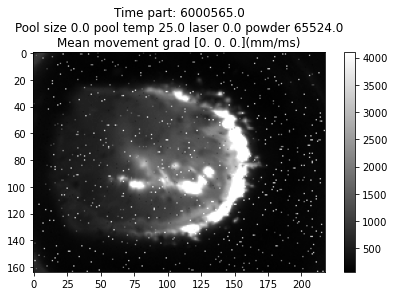

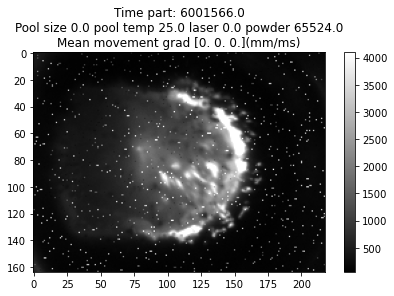

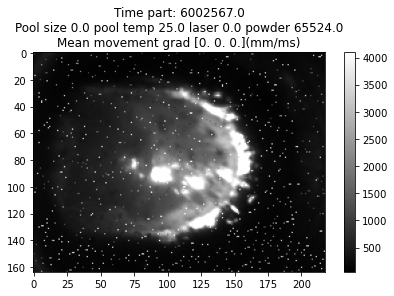

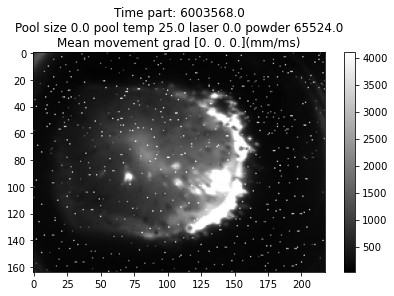

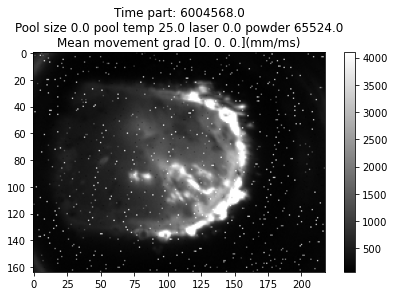

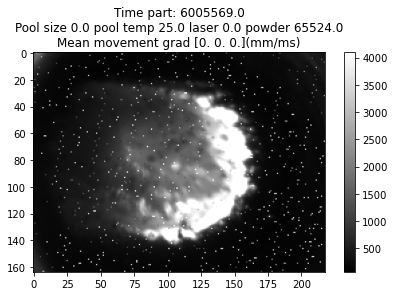

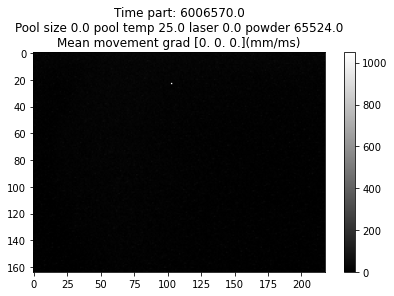

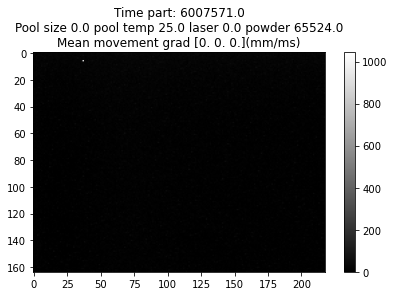

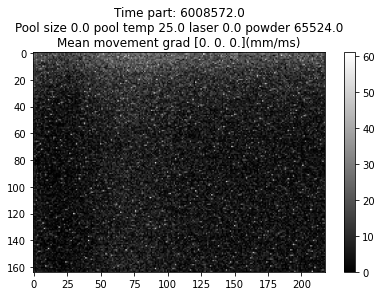

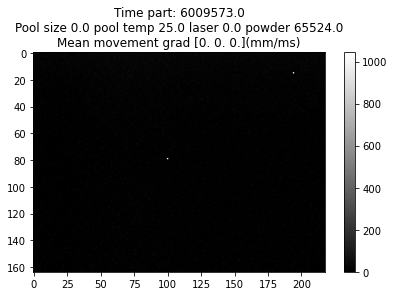

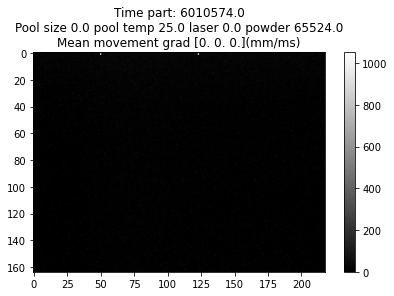

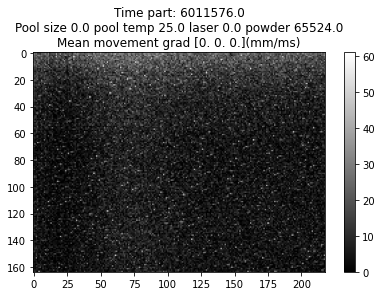

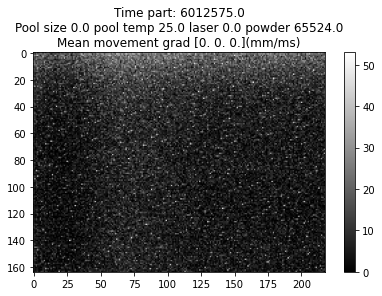

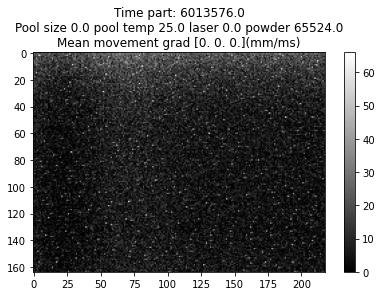

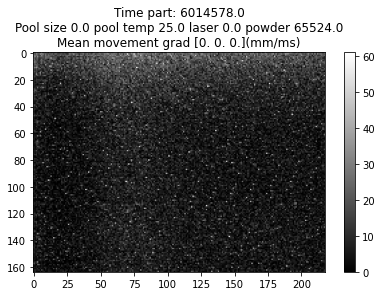

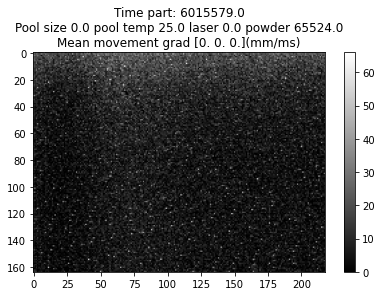

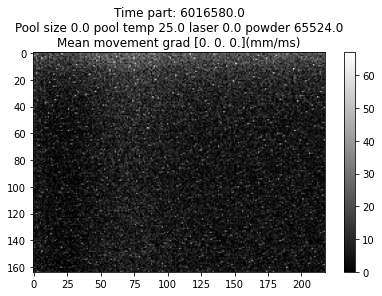

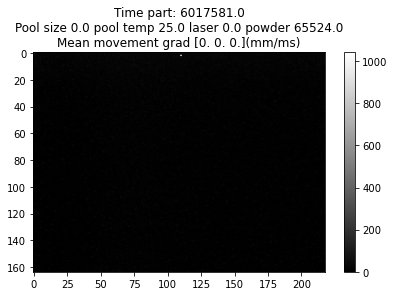

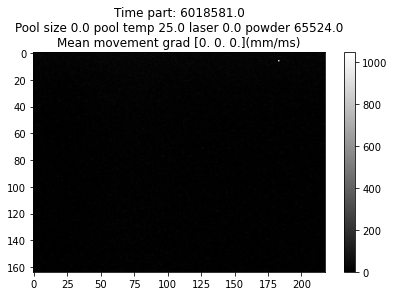

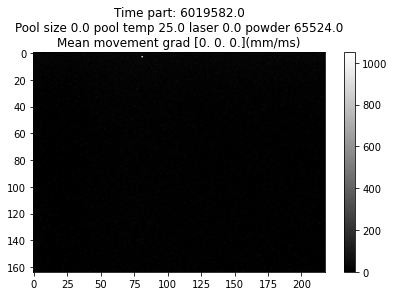

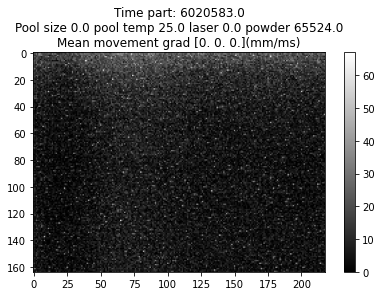

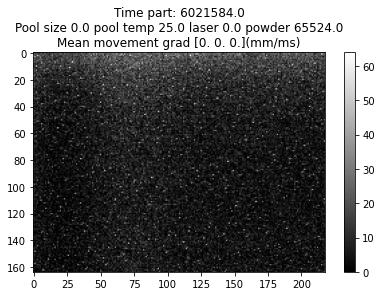

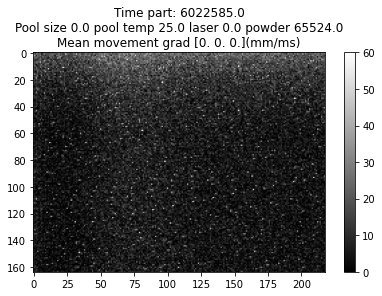

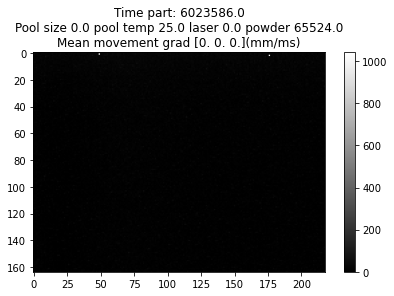

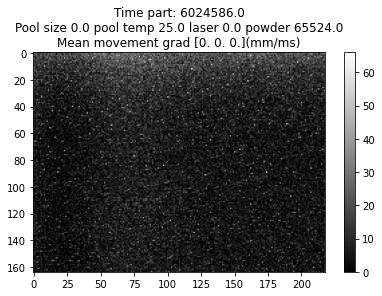

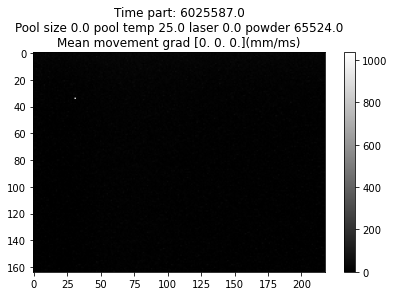

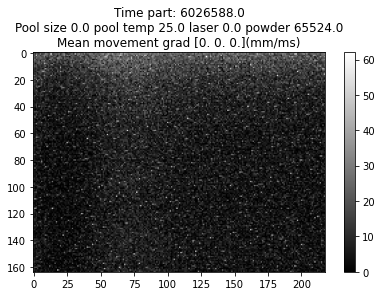

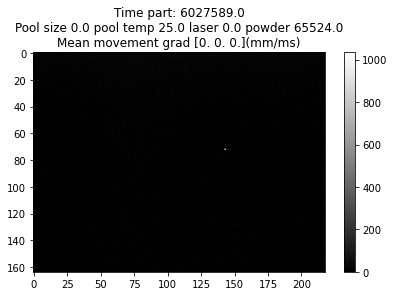

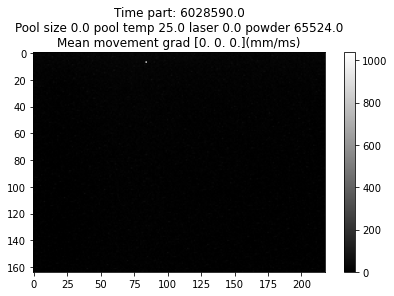

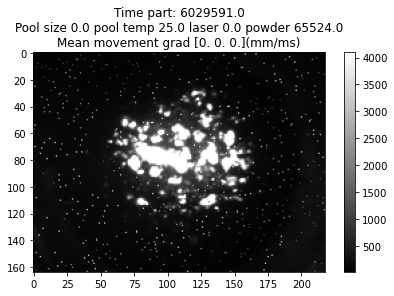

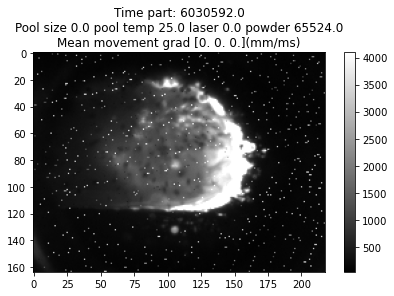

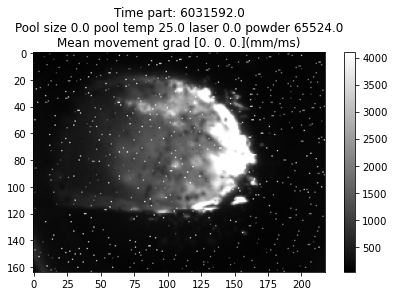

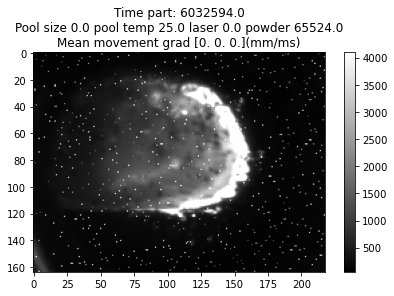

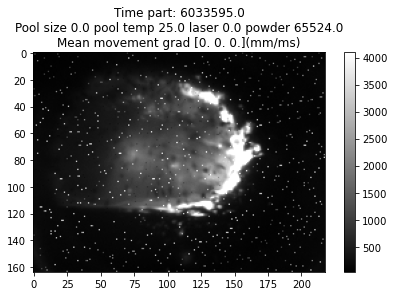

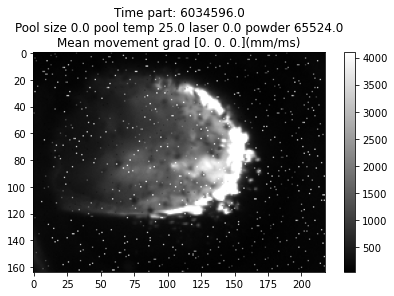

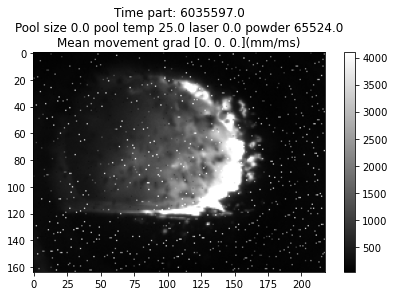

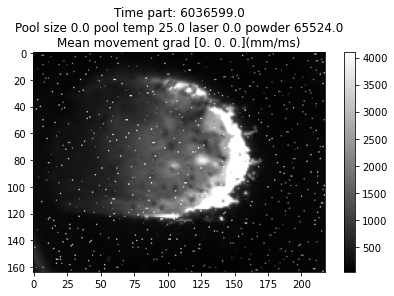

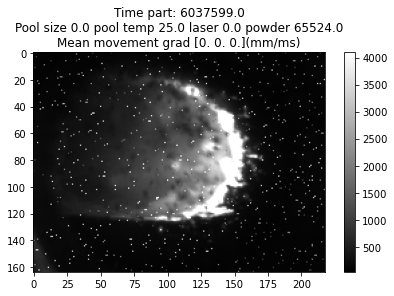

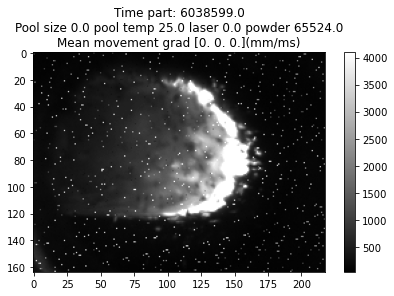

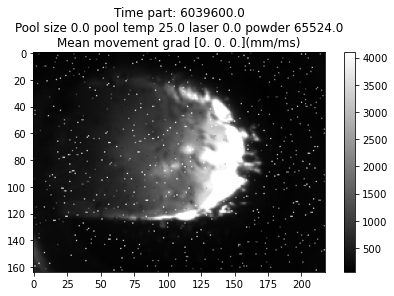

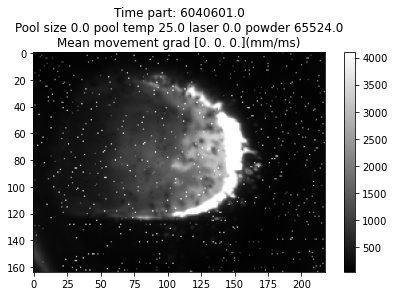

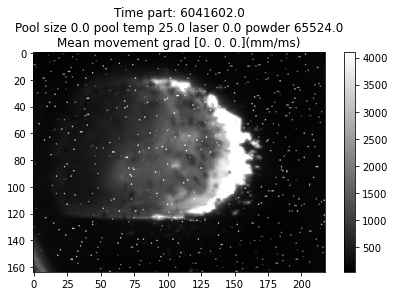

In [69]:
for i in roi_frame_names:
    this_frame_path = os.path.join(frame_path, i)
    frame = read_frame(this_frame_path)
    
    value = grab_func(i)
    corresp_rows = subset.iloc[np.abs(subset["t"] - value).argsort()[:5]]
    # Just find the diffs between pooints
    translations = np.diff(corresp_rows.sort_index()[["t", "x", "y", "z"]].values, axis=0)
    # Divide by time diff, should be mm/ms
    grad = translations[:, 1:] / translations[:,:1]
    # Mean grads in x-y-z
    mean_grad = np.mean(grad, axis=0)
    
    fig, ax = plt.subplots()
    imshow_result = ax.imshow(frame, cmap='gray')
    fig.colorbar(imshow_result)
    ax.set_title("Time part: {}\nPool size {} pool temp {} laser {} powder {}\nMean movement grad {}(mm/ms)".format(
        grab_func(i),
        corresp_rows["meltpoolSize"].mean(),
        corresp_rows["meltpoolTemp"].mean(),
        corresp_rows["LaserPower"].mean(),
        corresp_rows["flowWatch"].mean(),
        mean_grad
        
    ))
    fig.tight_layout()
    plt.show()

In [70]:
subset = data_df[
    (data_df["t(min)"] > 100)
    & (data_df["t(min)"] < 100.5)
    & (data_df["flowWatch"] > 3000)
]

subset

t       x       y        z    a    c  meltpoolSize  meltpoolTemp  \
59824  6013614  37.525  -0.602  128.600  0.0  0.0             0          25.0   
59825  6013714  37.525  -0.602  128.600  0.0  0.0             0          25.0   
59826  6013814  37.525  -0.602  128.600  0.0  0.0             0          25.0   
59827  6013914  37.525  -0.602  128.600  0.0  0.0             0          25.0   
59828  6014014  37.525  -0.602  128.600  0.0  0.0             0          25.0   
...        ...     ...     ...      ...  ...  ...           ...           ...   
59971  6028314  34.759  -9.837  129.945  0.0  0.0             0          25.0   
59972  6028414  34.306 -11.348  130.001  0.0  0.0             0          25.0   
59973  6028514  33.853 -12.860  130.058  0.0  0.0             0          25.0   
59974  6028614  33.400 -14.371  130.114  0.0  0.0             0          25.0   
59975  6028714  32.947 -15.883  130.171  0.0  0.0             0          25.0   

       LaserPower  stirrerValue_1  revolutionSpeed_1  powderGasFlow_1  \
59824           0             500                400              600   
59825           0             500                400              600   
59826           0             500                400              600   
59827           0             500                400              600   
59828           0             500                400              600   
...           ...             ...                ...              ...   
59971           0             500                400              600   
59972           0             500                400              600   
59973           0             500                400              600   
59974           0             500                400              600   
59975           0             500                400              600   

       stirrerValue_2  revolutionSpeed_2  powderGasFlow_2  flowWatch  \
59824               0                  0                0      65524   
59825               0                  0                0      65524   
59826               0                  0                0      65524   
59827               0                  0                0      65524   
59828               0                  0                0      65524   
...               ...                ...              ...        ...   
59971               0                  0                0       3072   
59972               0                  0                0       3072   
59973               0                  0                0       3072   
59974               0                  0                0       3072   
59975               0                  0                0       3072   

       meltpoolThreshold  protectionGlasTemperature      t(s)      t(min)  
59824                506                       33.5  6013.614  100.226900  
59825                506                       33.5  6013.714  100.228567  
59826                506                       33.5  6013.814  100.230233  
59827                506                       33.5  6013.914  100.231900  
59828                506                       33.5  6014.014  100.233567  
...                  ...                        ...       ...         ...  
59971                506                       31.1  6028.314  100.471900  
59972                506                       31.1  6028.414  100.473567  
59973                506                       31.1  6028.514  100.475233  
59974                506                       31.1  6028.614  100.476900  
59975                506                       31.1  6028.714  100.478567  

[91 rows x 20 columns]

In [71]:
subset = data_df[
    (data_df["revolutionSpeed_1"] < 400)
]
print(len(data_df))
subset

68304


t       x      y      z    a    c  meltpoolSize  meltpoolTemp  \
68299  6861120  37.172  5.168  137.6  0.0  0.0             0          25.0   
68300  6861220  37.172  5.168  137.6  0.0  0.0             0          25.0   
68301  6861320  37.172  5.168  137.6  0.0  0.0             0          25.0   
68302  6861420  37.172  5.168  137.6  0.0  0.0             0          25.0   
68303  6861520  37.172  5.168  137.6  0.0  0.0             0          25.0   

       LaserPower  stirrerValue_1  revolutionSpeed_1  powderGasFlow_1  \
68299           0               0                  0                0   
68300           0               0                  0                0   
68301           0               0                  0                0   
68302           0               0                  0                0   
68303           0               0                  0                0   

       stirrerValue_2  revolutionSpeed_2  powderGasFlow_2  flowWatch  \
68299               0                  0                0       2804   
68300               0                  0                0       2748   
68301               0                  0                0       2748   
68302               0                  0                0       2748   
68303               0                  0                0       2748   

       meltpoolThreshold  protectionGlasTemperature     t(s)      t(min)  
68299                506                       27.8  6861.12  114.352000  
68300                506                       27.8  6861.22  114.353667  
68301                506                       27.8  6861.32  114.355333  
68302                506                       27.8  6861.42  114.357000  
68303                506                       27.8  6861.52  114.358667

We have a couple of rows at the end where the machine appears to be turned off, but logging values

In [72]:
2**16

65536

Inputs to powder flow don't really change, but there's sections towards the end where it blows up



And now I start looking at plotting paths of the logfiles

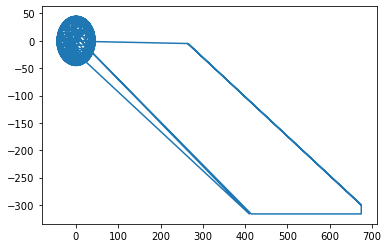

In [75]:
fig, ax = plt.subplots()
ax.plot(data_df["x"], data_df["y"])
plt.show()

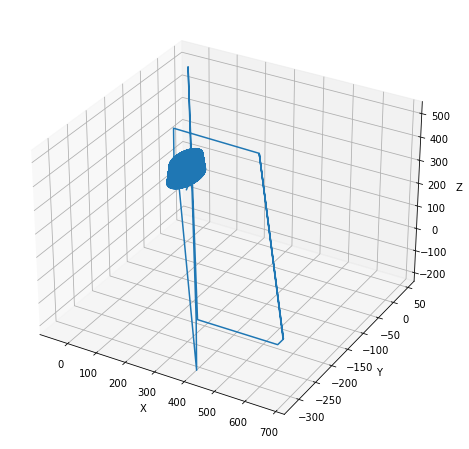

In [76]:
subset = data_df[
    data_df["t(min)"] > -1
]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.plot(subset["x"], subset["y"], subset["z"])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

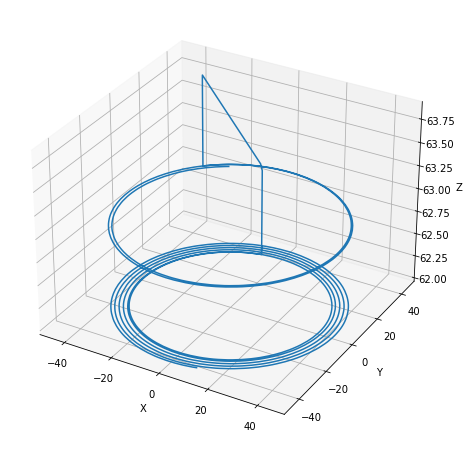

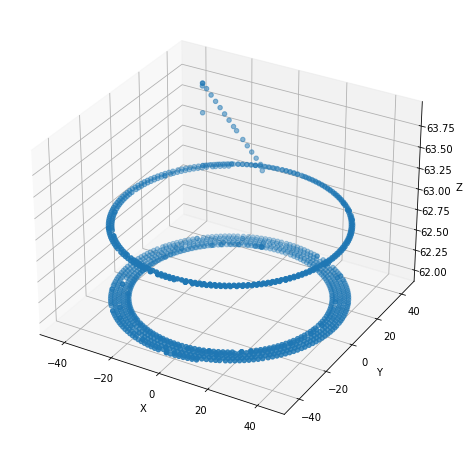

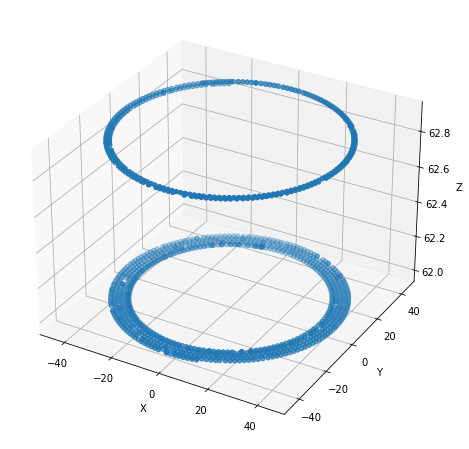

In [77]:
subset = data_df[
    (data_df["t(min)"] > 1.5)
    & (data_df["t(min)"] < 3.5)
]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.plot(subset["x"], subset["y"], subset["z"])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

subset = data_df[
    (data_df["t(min)"] > 1.5)
    & (data_df["t(min)"] < 3.5)
]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(subset["x"], subset["y"], subset["z"])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

subset = data_df[
    (data_df["t(min)"] > 1.5)
    & (data_df["t(min)"] < 3.5)
    & (data_df["LaserPower"] > 0)
]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(subset["x"], subset["y"], subset["z"])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [78]:
subset = data_df[
    data_df["z"] < 0
]
subset

t        x        y        z        a     c  meltpoolSize  \
343  65501  410.068 -316.544 -222.977  113.725 -30.0             0   
344  65601  410.068 -316.544 -215.777  113.725 -30.0             0   
345  65701  410.068 -316.544 -209.377  113.725 -30.0             0   
346  65801  410.068 -316.544 -202.443  113.725 -30.0             0   
347  65901  410.068 -316.544 -196.043  113.725 -30.0             0   
..     ...      ...      ...      ...      ...   ...           ...   
404  71601  649.185 -316.544   -1.000  113.725 -30.0             0   
405  71701  663.585 -316.544   -1.000  113.725 -30.0             0   
406  71801  674.968 -316.544   -1.000  113.725 -30.0             0   
407  71901  675.000 -313.960   -1.000  113.725 -30.0             0   
408  72001  675.000 -300.775   -1.000  113.725 -30.0             0   

     meltpoolTemp  LaserPower  stirrerValue_1  revolutionSpeed_1  \
343          25.0           0             500                400   
344          25.0           0             500                400   
345          25.0           0             500                400   
346          25.0           0             500                400   
347          25.0           0             500                400   
..            ...         ...             ...                ...   
404          25.0           0             500                400   
405          25.0           0             500                400   
406          25.0           0             500                400   
407          25.0           0             500                400   
408          25.0           0             500                400   

     powderGasFlow_1  stirrerValue_2  revolutionSpeed_2  powderGasFlow_2  \
343              600               0                  0                0   
344              600               0                  0                0   
345              600               0                  0                0   
346              600               0                  0                0   
347              600               0                  0                0   
..               ...             ...                ...              ...   
404              600               0                  0                0   
405              600               0                  0                0   
406              600               0                  0                0   
407              600               0                  0                0   
408              600               0                  0                0   

     flowWatch  meltpoolThreshold  protectionGlasTemperature    t(s)    t(min)  
343       2796                506                       25.6  65.501  1.091683  
344       2796                506                       25.6  65.601  1.093350  
345       2796                506                       25.6  65.701  1.095017  
346       2796                506                       25.6  65.801  1.096683  
347       2796                506                       25.6  65.901  1.098350  
..         ...                ...                        ...     ...       ...  
404       2864                506                       23.1  71.601  1.193350  
405       2864                506                       23.1  71.701  1.195017  
406       2864                506                       23.1  71.801  1.196683  
407       2864                506                       23.1  71.901  1.198350  
408       2864                506                       23.1  72.001  1.200017  

[65 rows x 20 columns]

Would be good to have an idea about melt pool size expected variance